# Deep-Q networks (DQN)

## Table of contents

1. [Understanding Deep-Q Networks (DQN)](#understanding-deep-q-networks-dqn)
2. [Setting up the environment](#setting-up-the-environment)
3. [Defining the environment for training](#defining-the-environment-for-training)
4. [Building the DQN architecture](#building-the-dqn-architecture)
5. [Implementing the experience replay buffer](#implementing-the-experience-replay-buffer)
6. [Implementing the action selection policy](#implementing-the-action-selection-policy)
7. [Training the DQN agent](#training-the-dqn-agent)
8. [Evaluating the agent's performance](#evaluating-the-agents-performance)
9. [Experimenting with hyperparameters](#experimenting-with-hyperparameters)

## Understanding Deep-Q networks (DQN)

### **Key concepts**
Deep Q-Networks (DQNs) are a foundational reinforcement learning algorithm that combines Q-learning with deep neural networks to solve complex decision-making tasks. DQNs use a neural network to approximate the Q-value function, which predicts the expected cumulative reward for taking an action in a given state. This approach enables agents to handle high-dimensional state spaces, such as those found in video games or robotics.

Key features of DQNs include:
- **Q-Learning**: A model-free reinforcement learning algorithm used to learn the optimal action-value function.
- **Experience Replay**: Stores past experiences in a buffer and samples batches of experiences to break correlation and improve learning stability.
- **Target Network**: A separate, periodically updated network to stabilize Q-value updates and reduce oscillations.
- **Action Selection**: Uses an epsilon-greedy policy to balance exploration (trying new actions) and exploitation (leveraging learned knowledge).

By combining deep learning with reinforcement learning, DQNs achieve remarkable performance in environments with complex, high-dimensional inputs.

### **Applications**
DQNs are widely applied to tasks requiring sequential decision-making, including:
- **Video games**: Achieving superhuman performance in games like Atari.
- **Robotics**: Enabling robots to learn tasks such as navigation and manipulation.
- **Autonomous vehicles**: Decision-making in dynamic driving environments.
- **Industrial automation**: Optimizing resource allocation and scheduling tasks.

### **Advantages**
- **High-dimensional input handling**: Uses deep neural networks to process complex inputs like images.
- **Sample efficiency**: Experience replay improves learning efficiency by reusing past experiences.
- **Scalability**: Can be adapted to a wide range of tasks and environments.
- **General-purpose algorithm**: Applicable to both discrete and continuous action spaces with modifications.

### **Challenges**
- **Training instability**: Sensitive to hyperparameters and requires careful tuning.
- **Exploration-exploitation tradeoff**: Striking the right balance is critical for effective learning.
- **Memory and computational cost**: Experience replay and neural network updates demand significant resources.
- **Sparse rewards**: Struggles in environments with delayed or infrequent rewards.

## Setting up the environment


##### **Q1: How do you install the necessary libraries for building and training a DQN in PyTorch?**


In [143]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install numpy matplotlib scikit-learn pandas
# !pip install gymnasium

##### **Q2: How do you import the required modules for building the DQN architecture and handling the environment in PyTorch?**


In [144]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

##### **Q3: How do you configure your environment to use GPU support for training the DQN in PyTorch?**

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Defining the environment for training


##### **Q4: How do you load an environment from OpenAI Gym for training a DQN agent?**


In [146]:
env = gym.make('CartPole-v1')

##### **Q5: How do you retrieve the state and action space from the Gym environment to define the DQN input and output?**


In [147]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print(f"State size: {state_size}, Action size: {action_size}")

State size: 4, Action size: 2


##### **Q6: How do you reset the environment in Gym and retrieve the initial state for training the agent?**

In [148]:
state, info = env.reset()
state = torch.from_numpy(state).float().unsqueeze(0).to(device)

## Building the DQN architecture


##### **Q7: How do you define the architecture of the Q-network using `torch.nn.Module` in PyTorch?**


In [149]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_layers=[128, 128]):
        super(DQN, self).__init__()
        layers = []
        input_size = state_size
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, action_size))
        self.model = nn.Sequential(*layers)
        self.init_weights()  # Initialize weights
    
    def init_weights(self):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Kaiming initialization
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.model(x)

##### **Q8: How do you implement the forward pass of the DQN to predict Q-values given a state?**


In [150]:
# See forward pass above

##### **Q9: How do you initialize the weights of the Q-network to ensure stable training?**

In [151]:
# See weight initialization above

## Implementing the experience replay buffer


##### **Q10: How do you create an experience replay buffer to store state transitions (state, action, reward, next state)?**


In [152]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)  # Limit size to prevent memory overflow
    
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # Add new transition
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  # Sample a batch
    
    def __len__(self):
        return len(self.memory)

##### **Q11: How do you implement a method to add new transitions to the experience replay buffer?**


In [153]:
# See the "push" method above

##### **Q12: How do you sample mini-batches of experiences from the replay buffer to train the DQN?**


In [154]:
# See the "sample" method above

##### **Q13: How do you limit the size of the replay buffer to prevent memory overflow during training?**

In [155]:
# See the "__init__" method above

## Implementing the action selection policy


##### **Q14: How do you implement an epsilon-greedy policy for selecting actions based on Q-values predicted by the DQN?**


In [156]:
def select_action(state, policy_net, epsilon):
    if random.random() < epsilon:
        return torch.tensor([[random.randrange(action_size)]], device=device, dtype=torch.long)  # Random action
    else:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)  # Greedy action

##### **Q15: How do you decay the epsilon value over time to gradually shift from exploration to exploitation?**


In [157]:
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995

epsilon = epsilon_start

# After each episode:
epsilon = max(epsilon_end, epsilon * epsilon_decay)

##### **Q16: How do you select an action using the epsilon-greedy policy during training and switch to a greedy policy during evaluation?**

In [158]:
# action = select_action(state, policy_net, epsilon)

In [159]:
# epsilon = 0.0  # Set epsilon to zero for a greedy policy
# action = select_action(state, policy_net, epsilon)

## Training the DQN agent


##### **Q17: How do you implement the training loop for the DQN, including resetting the environment and selecting actions using the epsilon-greedy policy?**


In [160]:
def train_dqn(
    env,
    num_episodes=500,
    batch_size=64,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.995,
    target_update=10,
    memory_capacity=10000,
    learning_rate=0.001,
    hidden_layers=[128, 128],
    verbose=False
):
    # Initialize networks:
    policy_net = DQN(state_size, action_size, hidden_layers).to(device)
    target_net = DQN(state_size, action_size, hidden_layers).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Initialize optimizer and memory:
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayMemory(memory_capacity)

    epsilon = epsilon_start  # Initialize epsilon

    episode_rewards = []
    losses = []

    for episode in range(num_episodes):
        state, info = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        total_reward = 0

        for t in range(1, 10000):
            action = select_action(state, policy_net, epsilon)  # Select action

            # Take action:
            next_state, reward, terminated, truncated, info = env.step(action.item())
            total_reward += reward
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            # Process next state:
            if not done:
                next_state_tensor = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            else:
                next_state_tensor = None

            memory.push(state, action, reward, next_state_tensor, done)  # Store transition

            state = next_state_tensor  # Move to next state

            # Perform optimization:
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = list(zip(*transitions))

                state_batch = torch.cat(batch[0])
                action_batch = torch.cat(batch[1])
                reward_batch = torch.cat(batch[2])
                non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[3])), device=device, dtype=torch.bool)
                non_final_next_states = torch.cat([s for s in batch[3] if s is not None])

                state_action_values = policy_net(state_batch).gather(1, action_batch)  # Compute Q(s_t, a)

                # Compute V(s_{t+1}):
                next_state_values = torch.zeros(batch_size, device=device)
                with torch.no_grad():
                    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

                expected_state_action_values = (next_state_values * gamma) + reward_batch  # Compute expected Q values

                criterion = nn.SmoothL1Loss()
                loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
                losses.append(loss.item())

                optimizer.zero_grad()
                loss.backward()
                for param in policy_net.parameters():
                    param.grad.data.clamp_(-1, 1)
                optimizer.step()

            if done:
                episode_rewards.append(total_reward)
                break

        # Update target network:
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_end, epsilon * epsilon_decay)  # Decay epsilon

        if verbose and episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

    fig, axs = plt.subplots(2, 1, figsize=(12, 8))
    axs[0].plot(episode_rewards)
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Total Reward per Episode')

    axs[1].plot(losses)
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss during Training')

    plt.tight_layout()
    plt.show()

    return policy_net, episode_rewards, losses

Episode 0, Total Reward: 17.0, Epsilon: 0.99
Episode 10, Total Reward: 17.0, Epsilon: 0.95
Episode 20, Total Reward: 34.0, Epsilon: 0.90
Episode 30, Total Reward: 16.0, Epsilon: 0.86
Episode 40, Total Reward: 14.0, Epsilon: 0.81
Episode 50, Total Reward: 20.0, Epsilon: 0.77
Episode 60, Total Reward: 41.0, Epsilon: 0.74
Episode 70, Total Reward: 13.0, Epsilon: 0.70
Episode 80, Total Reward: 68.0, Epsilon: 0.67
Episode 90, Total Reward: 53.0, Epsilon: 0.63
Episode 100, Total Reward: 16.0, Epsilon: 0.60
Episode 110, Total Reward: 65.0, Epsilon: 0.57
Episode 120, Total Reward: 40.0, Epsilon: 0.55
Episode 130, Total Reward: 31.0, Epsilon: 0.52
Episode 140, Total Reward: 26.0, Epsilon: 0.49
Episode 150, Total Reward: 56.0, Epsilon: 0.47
Episode 160, Total Reward: 51.0, Epsilon: 0.45
Episode 170, Total Reward: 59.0, Epsilon: 0.42
Episode 180, Total Reward: 21.0, Epsilon: 0.40
Episode 190, Total Reward: 93.0, Epsilon: 0.38
Episode 200, Total Reward: 133.0, Epsilon: 0.37
Episode 210, Total Rewa

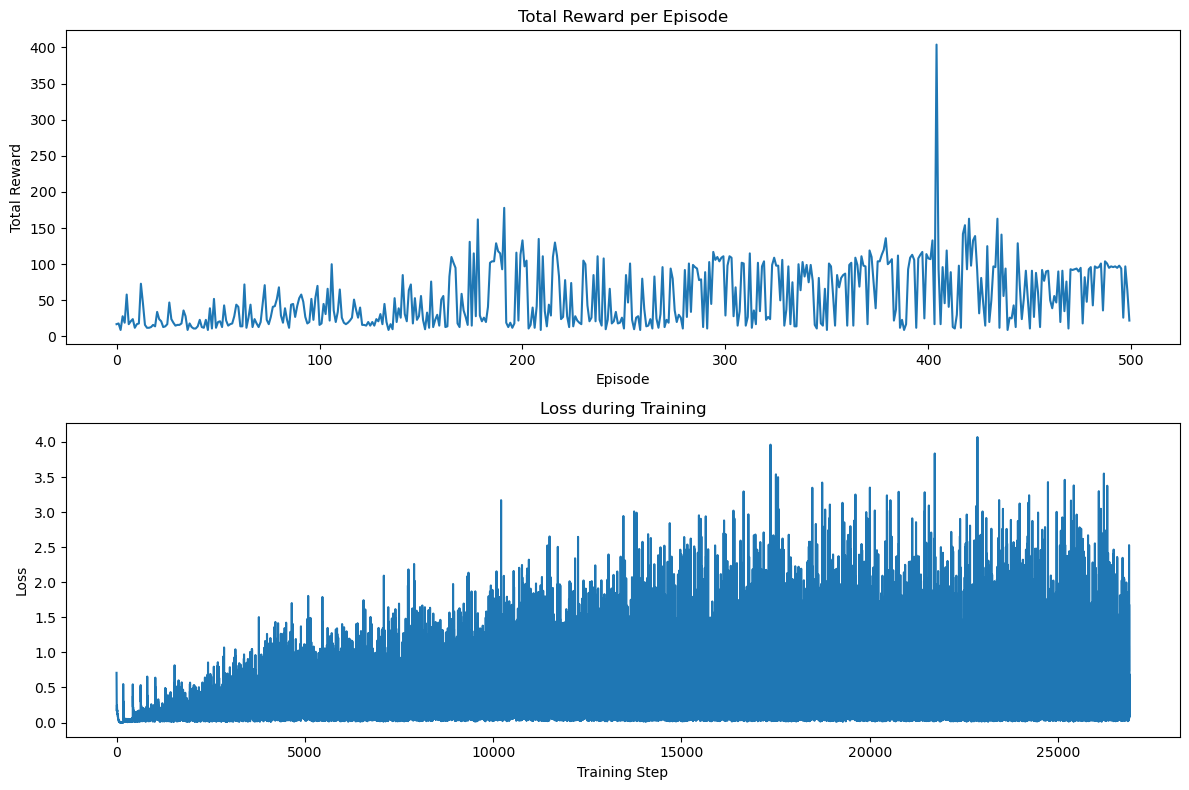

In [176]:
policy_net, episode_rewards, losses = train_dqn(env, num_episodes=500, verbose=True)

##### **Q18: How do you store transitions in the experience replay buffer after each interaction with the environment?**


In [162]:
# See how transitions are stored in the training loop, i.e.,
# memory.push(state, action, reward, next_state_tensor, done)

##### **Q19: How do you compute the target Q-values using the Bellman equation for updating the DQN?**


In [163]:
# In the training loop function above:
# state_action_values = policy_net(state_batch).gather(1, action_batch)  # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken

# Compute V(s_{t+1}) for all next states:
# next_state_values = torch.zeros(batch_size, device=device)
# with torch.no_grad():
#     next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

# expected_state_action_values = (next_state_values * gamma) + reward_batch  # Compute expected Q values

##### **Q20: How do you perform backpropagation and update the Q-network's weights using the loss between target and predicted Q-values?**


In [164]:
# See loss computation and optimization in the training loop above

##### **Q21: How do you periodically copy the weights from the main Q-network to the target network to stabilize training?**

In [165]:
# In the training loop:
# if episode % target_update == 0:
#     target_net.load_state_dict(policy_net.state_dict())

## Evaluating the agent's performance


##### **Q22: How do you evaluate the performance of the DQN agent on the Gym environment using a greedy policy (without exploration)?**


In [177]:
def evaluate_policy(policy_net, env, n_episodes=10):
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_values = policy_net(state)  # Should be a tensor
                action = q_values.max(1)[1].view(1, 1)  # Use 'max' method of tensor
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            total_reward += reward
            done = terminated or truncated
            if not done:
                state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
            else:
                break
        total_rewards.append(total_reward)
    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {n_episodes} evaluation episodes: {average_reward}")
    return total_rewards

In [178]:
evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)

Average Reward over 10 evaluation episodes: 96.0


##### **Q23: How do you visualize the cumulative reward the agent accumulates over episodes during evaluation?**


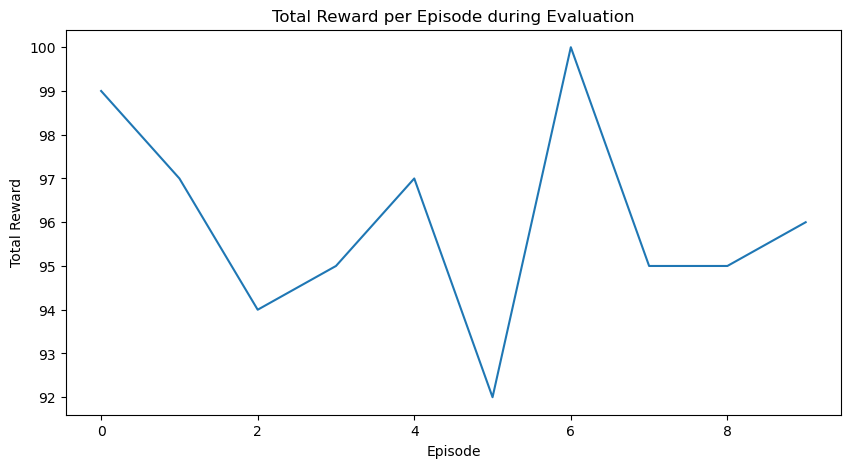

In [179]:
plt.figure(figsize=(10, 5))
plt.plot(evaluation_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode during Evaluation')
plt.show()

##### **Q24: How do you save and reload the trained DQN model to evaluate it on new episodes without retraining?**

In [180]:
torch.save(policy_net.state_dict(), 'dqn_cartpole_model.pth')

In [181]:
loaded_policy_net = DQN(state_size, action_size, hidden_layers=[128, 128]).to(device)
loaded_policy_net.load_state_dict(torch.load('dqn_cartpole_model.pth'))
loaded_policy_net.eval()

/tmp/ipykernel_324233/2784307154.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_policy_net.load_state_dict(torch.load('dqn_cartpole_model.pth'))


DQN(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [182]:
loaded_evaluation_rewards = evaluate_policy(loaded_policy_net, env, n_episodes=10)

Average Reward over 10 evaluation episodes: 95.5


## Experimenting with hyperparameters


##### **Q25: How do you adjust the learning rate and observe its impact on the training stability and performance of the DQN agent?**



Training with learning rate: 0.01
Episode 0, Total Reward: 41.0, Epsilon: 0.99
Episode 10, Total Reward: 11.0, Epsilon: 0.95
Episode 20, Total Reward: 10.0, Epsilon: 0.90
Episode 30, Total Reward: 21.0, Epsilon: 0.86
Episode 40, Total Reward: 15.0, Epsilon: 0.81
Episode 50, Total Reward: 20.0, Epsilon: 0.77
Episode 60, Total Reward: 16.0, Epsilon: 0.74
Episode 70, Total Reward: 39.0, Epsilon: 0.70
Episode 80, Total Reward: 71.0, Epsilon: 0.67
Episode 90, Total Reward: 40.0, Epsilon: 0.63
Episode 100, Total Reward: 22.0, Epsilon: 0.60
Episode 110, Total Reward: 38.0, Epsilon: 0.57
Episode 120, Total Reward: 33.0, Epsilon: 0.55
Episode 130, Total Reward: 96.0, Epsilon: 0.52
Episode 140, Total Reward: 11.0, Epsilon: 0.49
Episode 150, Total Reward: 16.0, Epsilon: 0.47
Episode 160, Total Reward: 78.0, Epsilon: 0.45
Episode 170, Total Reward: 15.0, Epsilon: 0.42
Episode 180, Total Reward: 14.0, Epsilon: 0.40
Episode 190, Total Reward: 23.0, Epsilon: 0.38


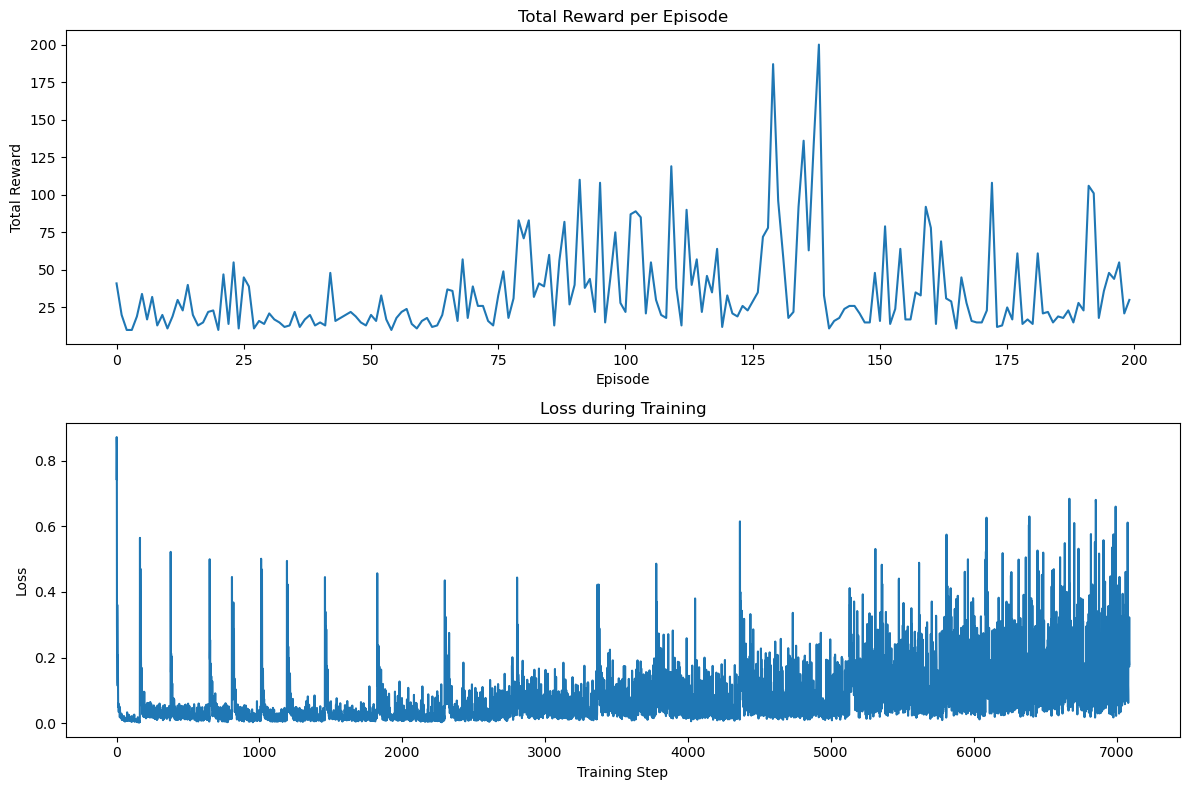

Average Reward over 10 evaluation episodes: 144.7

Training with learning rate: 0.001
Episode 0, Total Reward: 18.0, Epsilon: 0.99
Episode 10, Total Reward: 12.0, Epsilon: 0.95
Episode 20, Total Reward: 11.0, Epsilon: 0.90
Episode 30, Total Reward: 16.0, Epsilon: 0.86
Episode 40, Total Reward: 17.0, Epsilon: 0.81
Episode 50, Total Reward: 28.0, Epsilon: 0.77
Episode 60, Total Reward: 16.0, Epsilon: 0.74
Episode 70, Total Reward: 83.0, Epsilon: 0.70
Episode 80, Total Reward: 35.0, Epsilon: 0.67
Episode 90, Total Reward: 40.0, Epsilon: 0.63
Episode 100, Total Reward: 21.0, Epsilon: 0.60
Episode 110, Total Reward: 65.0, Epsilon: 0.57
Episode 120, Total Reward: 40.0, Epsilon: 0.55
Episode 130, Total Reward: 21.0, Epsilon: 0.52
Episode 140, Total Reward: 13.0, Epsilon: 0.49
Episode 150, Total Reward: 26.0, Epsilon: 0.47
Episode 160, Total Reward: 56.0, Epsilon: 0.45
Episode 170, Total Reward: 24.0, Epsilon: 0.42
Episode 180, Total Reward: 13.0, Epsilon: 0.40
Episode 190, Total Reward: 62.0,

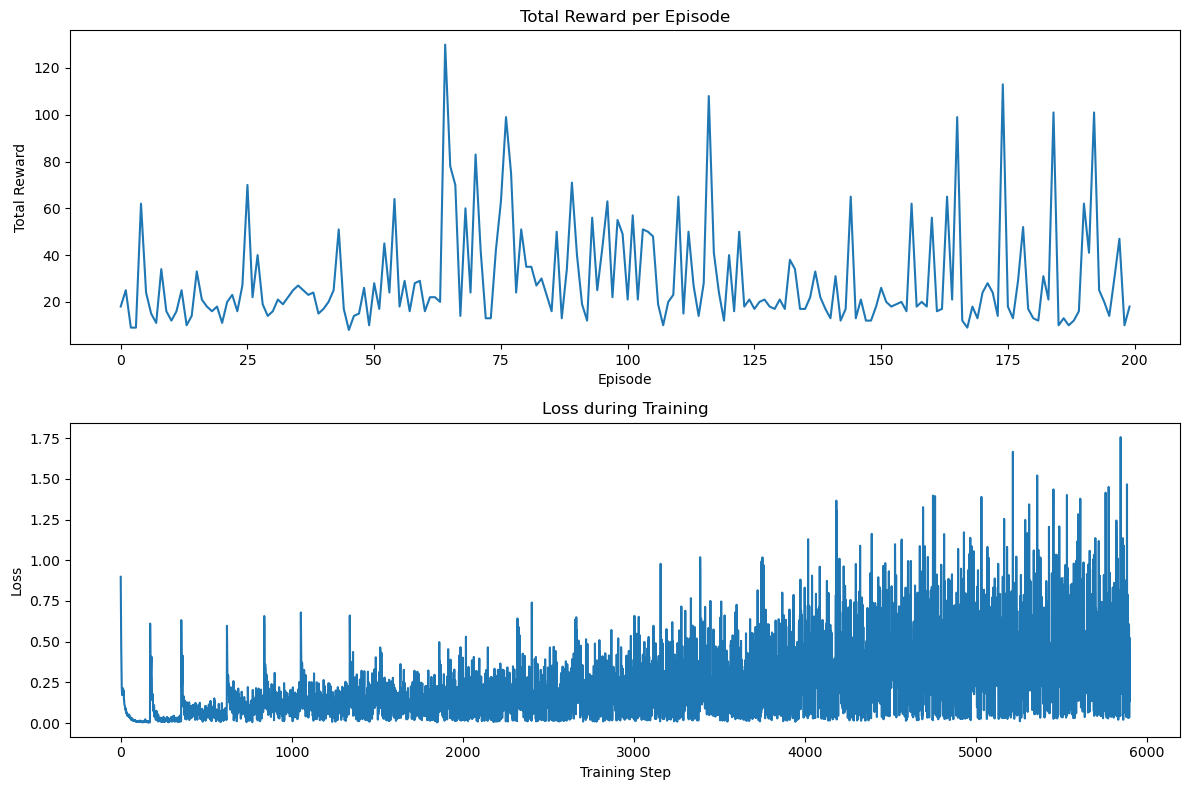

Average Reward over 10 evaluation episodes: 109.0

Training with learning rate: 0.0001
Episode 0, Total Reward: 14.0, Epsilon: 0.99
Episode 10, Total Reward: 13.0, Epsilon: 0.95
Episode 20, Total Reward: 12.0, Epsilon: 0.90
Episode 30, Total Reward: 18.0, Epsilon: 0.86
Episode 40, Total Reward: 16.0, Epsilon: 0.81
Episode 50, Total Reward: 9.0, Epsilon: 0.77
Episode 60, Total Reward: 14.0, Epsilon: 0.74
Episode 70, Total Reward: 11.0, Epsilon: 0.70
Episode 80, Total Reward: 16.0, Epsilon: 0.67
Episode 90, Total Reward: 10.0, Epsilon: 0.63
Episode 100, Total Reward: 12.0, Epsilon: 0.60
Episode 110, Total Reward: 10.0, Epsilon: 0.57
Episode 120, Total Reward: 14.0, Epsilon: 0.55
Episode 130, Total Reward: 14.0, Epsilon: 0.52
Episode 140, Total Reward: 22.0, Epsilon: 0.49
Episode 150, Total Reward: 15.0, Epsilon: 0.47
Episode 160, Total Reward: 10.0, Epsilon: 0.45
Episode 170, Total Reward: 14.0, Epsilon: 0.42
Episode 180, Total Reward: 9.0, Epsilon: 0.40
Episode 190, Total Reward: 15.0, 

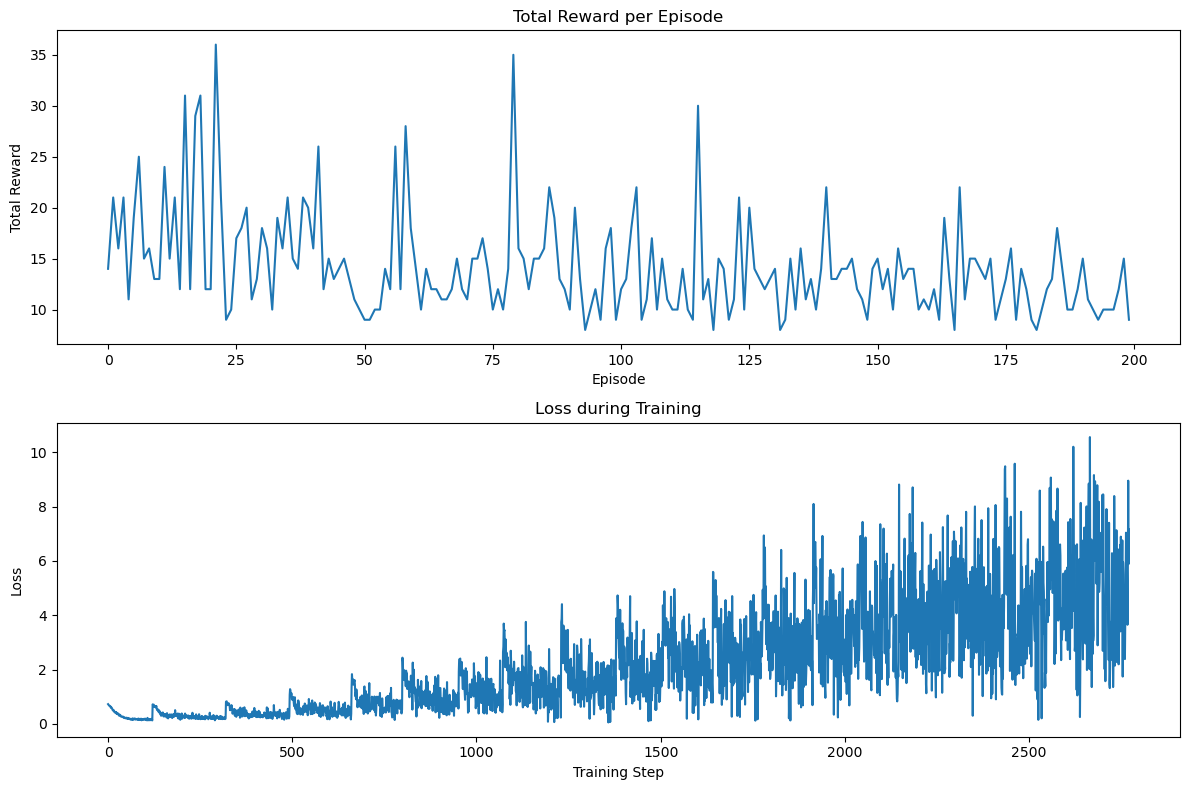

Average Reward over 10 evaluation episodes: 9.6


In [183]:
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        learning_rate=lr,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    results[lr] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

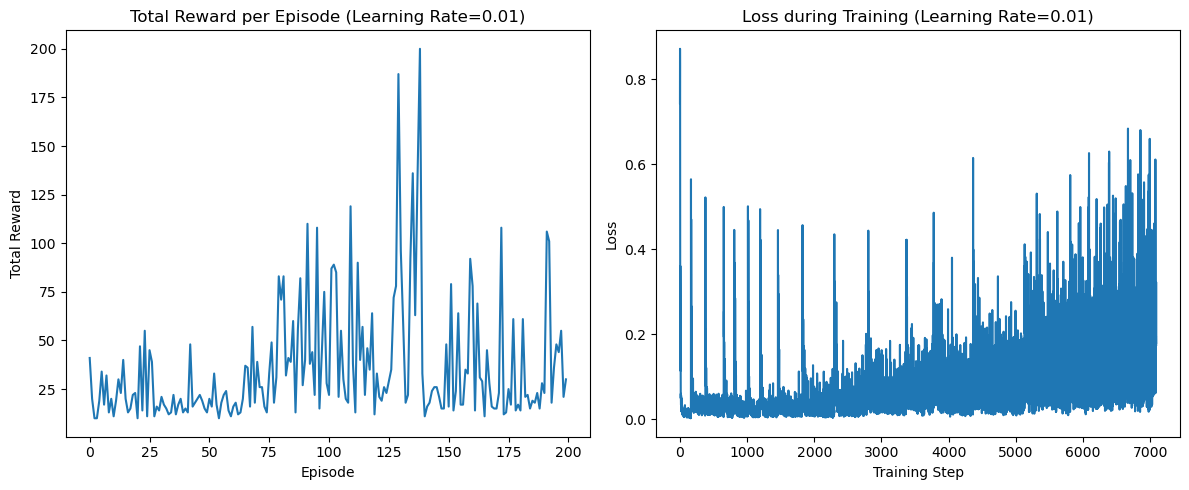

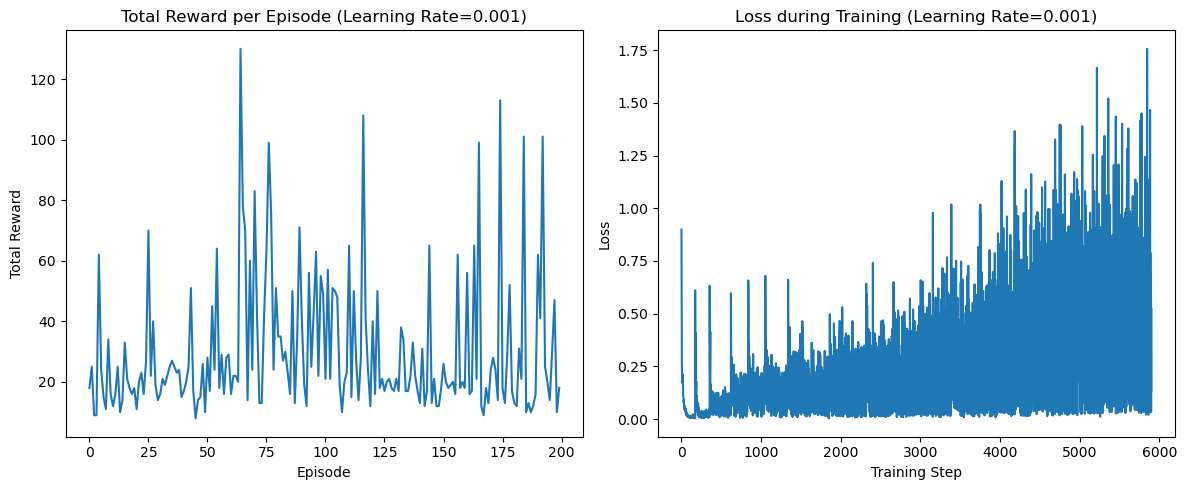

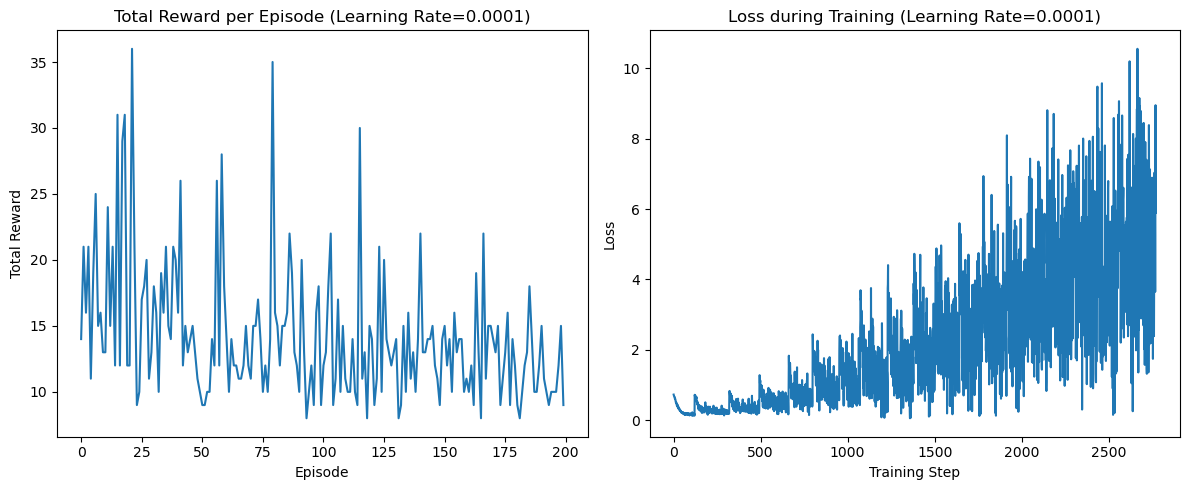

In [184]:
for lr in learning_rates:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results[lr]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Learning Rate={lr})')
    
    axs[1].plot(results[lr]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Learning Rate={lr})')
    plt.tight_layout()
    plt.show()

##### **Q26: How do you modify the discount factor (gamma) in the Bellman equation, and how does it affect the agent’s long-term reward optimization?**



Training with gamma: 0.9
Episode 0, Total Reward: 27.0, Epsilon: 0.99
Episode 10, Total Reward: 25.0, Epsilon: 0.95
Episode 20, Total Reward: 13.0, Epsilon: 0.90
Episode 30, Total Reward: 15.0, Epsilon: 0.86
Episode 40, Total Reward: 21.0, Epsilon: 0.81
Episode 50, Total Reward: 25.0, Epsilon: 0.77
Episode 60, Total Reward: 38.0, Epsilon: 0.74
Episode 70, Total Reward: 23.0, Epsilon: 0.70
Episode 80, Total Reward: 19.0, Epsilon: 0.67
Episode 90, Total Reward: 18.0, Epsilon: 0.63
Episode 100, Total Reward: 127.0, Epsilon: 0.60
Episode 110, Total Reward: 122.0, Epsilon: 0.57
Episode 120, Total Reward: 86.0, Epsilon: 0.55
Episode 130, Total Reward: 29.0, Epsilon: 0.52
Episode 140, Total Reward: 22.0, Epsilon: 0.49
Episode 150, Total Reward: 27.0, Epsilon: 0.47
Episode 160, Total Reward: 28.0, Epsilon: 0.45
Episode 170, Total Reward: 21.0, Epsilon: 0.42
Episode 180, Total Reward: 32.0, Epsilon: 0.40
Episode 190, Total Reward: 24.0, Epsilon: 0.38


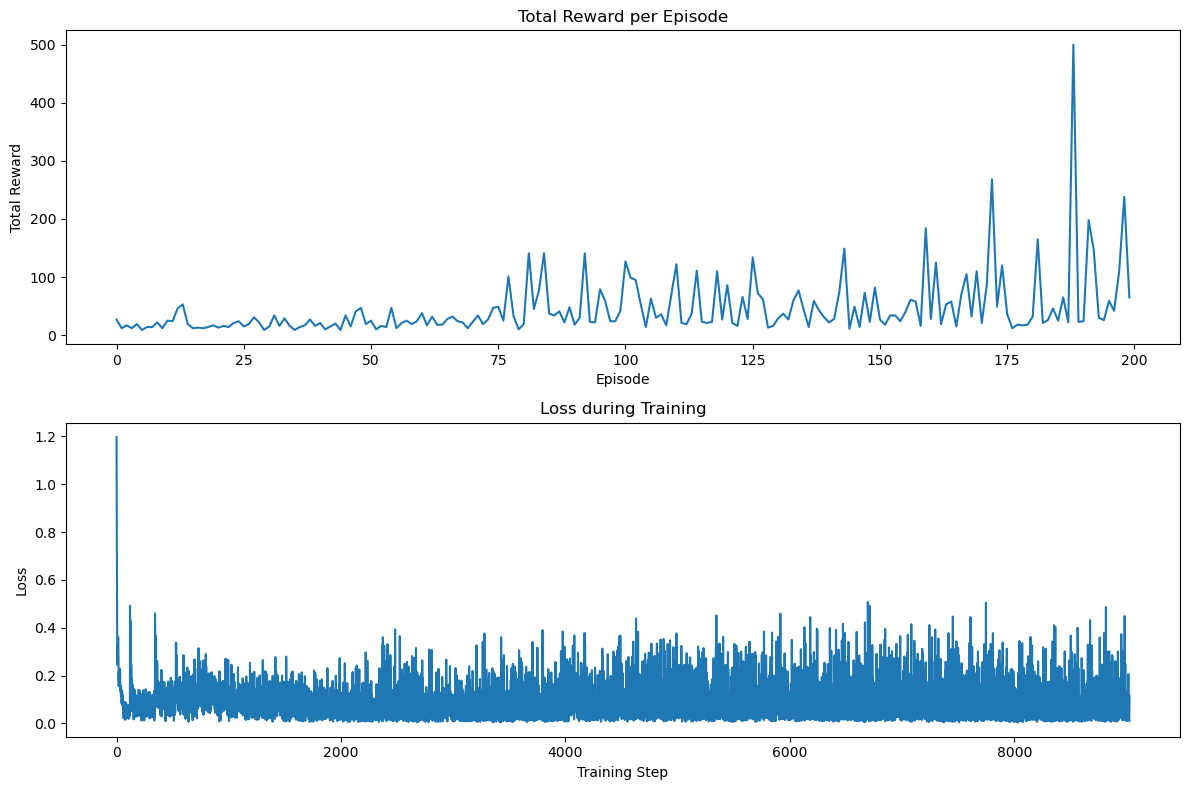

Average Reward over 10 evaluation episodes: 243.2

Training with gamma: 0.95
Episode 0, Total Reward: 20.0, Epsilon: 0.99
Episode 10, Total Reward: 12.0, Epsilon: 0.95
Episode 20, Total Reward: 12.0, Epsilon: 0.90
Episode 30, Total Reward: 87.0, Epsilon: 0.86
Episode 40, Total Reward: 12.0, Epsilon: 0.81
Episode 50, Total Reward: 33.0, Epsilon: 0.77
Episode 60, Total Reward: 19.0, Epsilon: 0.74
Episode 70, Total Reward: 25.0, Epsilon: 0.70
Episode 80, Total Reward: 93.0, Epsilon: 0.67
Episode 90, Total Reward: 84.0, Epsilon: 0.63
Episode 100, Total Reward: 74.0, Epsilon: 0.60
Episode 110, Total Reward: 61.0, Epsilon: 0.57
Episode 120, Total Reward: 106.0, Epsilon: 0.55
Episode 130, Total Reward: 24.0, Epsilon: 0.52
Episode 140, Total Reward: 116.0, Epsilon: 0.49
Episode 150, Total Reward: 21.0, Epsilon: 0.47
Episode 160, Total Reward: 29.0, Epsilon: 0.45
Episode 170, Total Reward: 42.0, Epsilon: 0.42
Episode 180, Total Reward: 107.0, Epsilon: 0.40
Episode 190, Total Reward: 19.0, Epsil

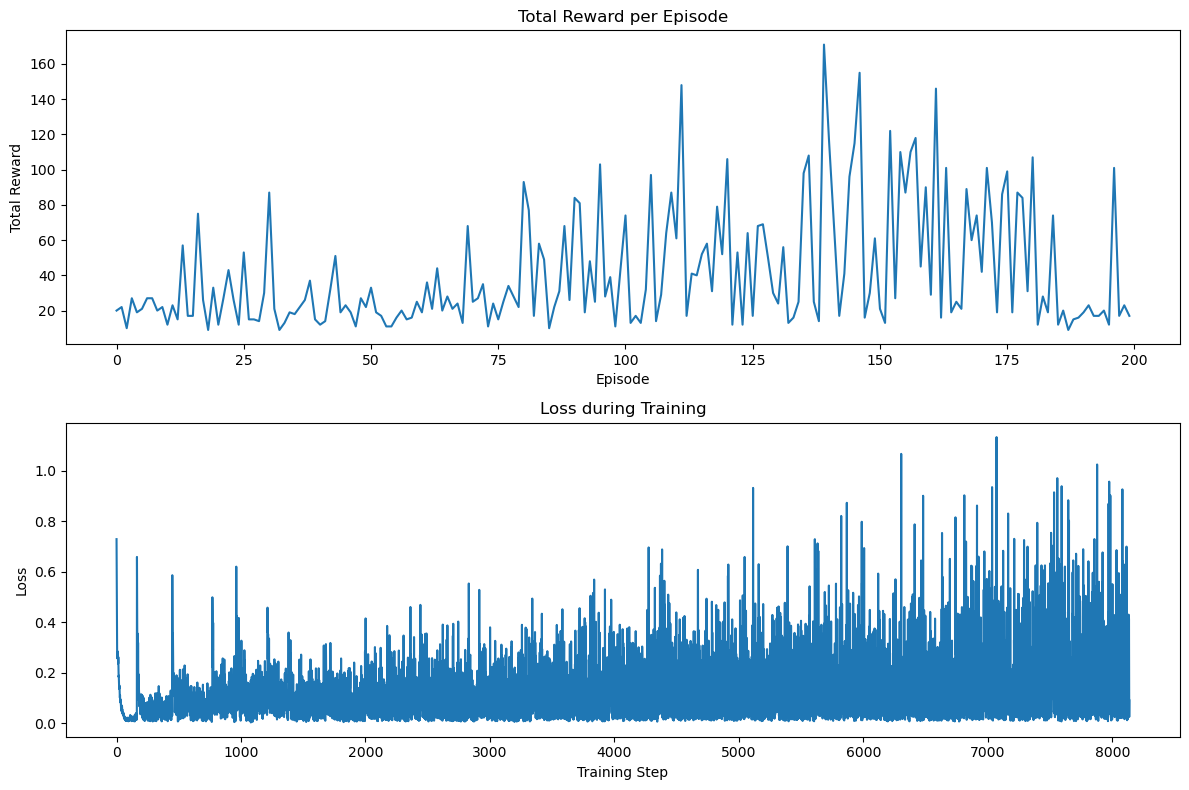

Average Reward over 10 evaluation episodes: 107.8

Training with gamma: 0.99
Episode 0, Total Reward: 37.0, Epsilon: 0.99
Episode 10, Total Reward: 17.0, Epsilon: 0.95
Episode 20, Total Reward: 22.0, Epsilon: 0.90
Episode 30, Total Reward: 24.0, Epsilon: 0.86
Episode 40, Total Reward: 12.0, Epsilon: 0.81
Episode 50, Total Reward: 17.0, Epsilon: 0.77
Episode 60, Total Reward: 14.0, Epsilon: 0.74
Episode 70, Total Reward: 90.0, Epsilon: 0.70
Episode 80, Total Reward: 88.0, Epsilon: 0.67
Episode 90, Total Reward: 81.0, Epsilon: 0.63
Episode 100, Total Reward: 23.0, Epsilon: 0.60
Episode 110, Total Reward: 19.0, Epsilon: 0.57
Episode 120, Total Reward: 24.0, Epsilon: 0.55
Episode 130, Total Reward: 16.0, Epsilon: 0.52
Episode 140, Total Reward: 82.0, Epsilon: 0.49
Episode 150, Total Reward: 20.0, Epsilon: 0.47
Episode 160, Total Reward: 13.0, Epsilon: 0.45
Episode 170, Total Reward: 26.0, Epsilon: 0.42
Episode 180, Total Reward: 105.0, Epsilon: 0.40
Episode 190, Total Reward: 39.0, Epsilon

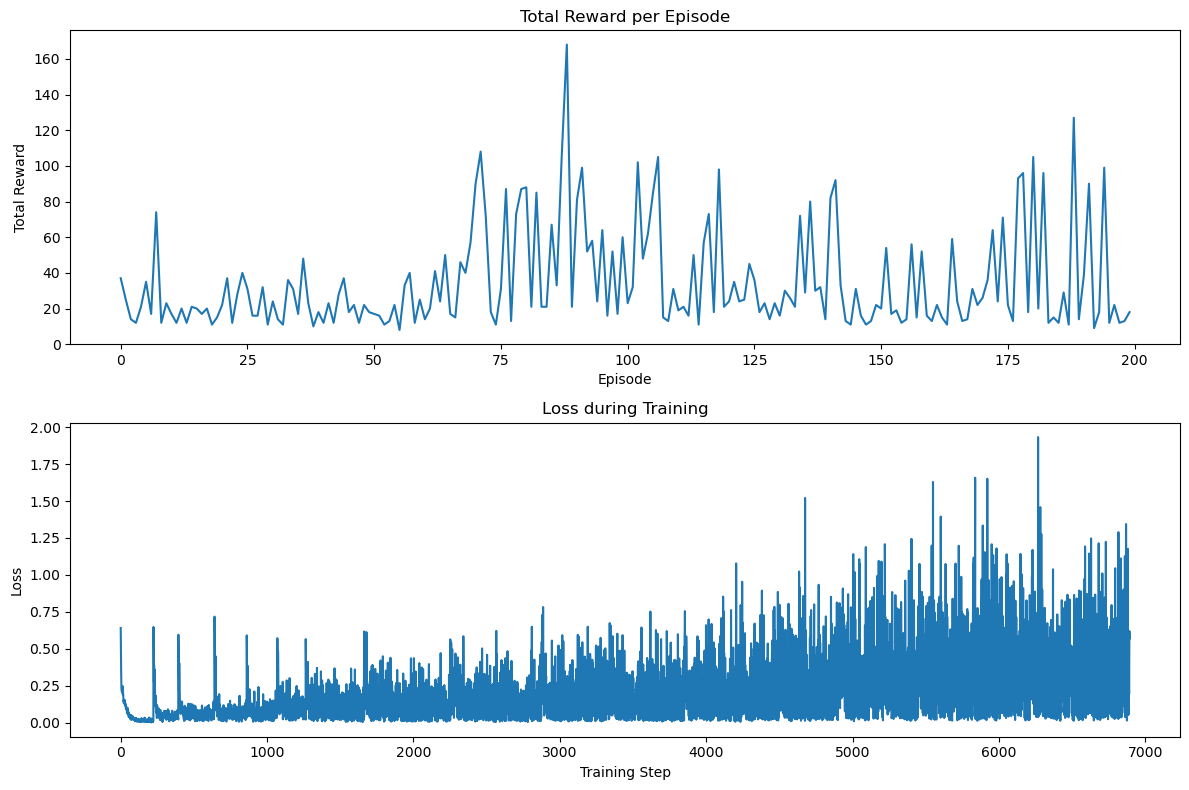

Average Reward over 10 evaluation episodes: 97.1


In [185]:
gammas = [0.90, 0.95, 0.99]
results_gamma = {}

for gamma in gammas:
    print(f"\nTraining with gamma: {gamma}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        gamma=gamma,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    results_gamma[gamma] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

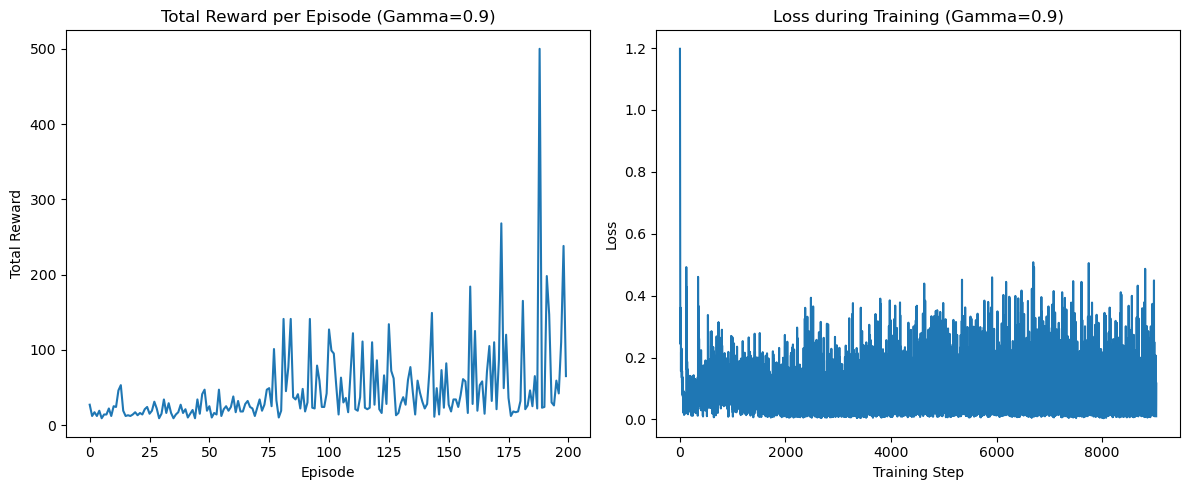

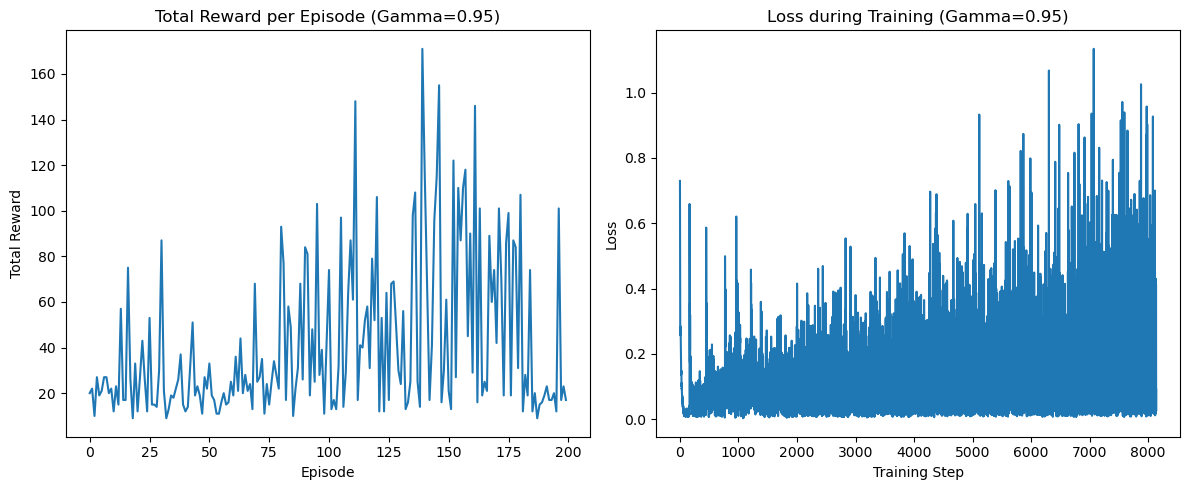

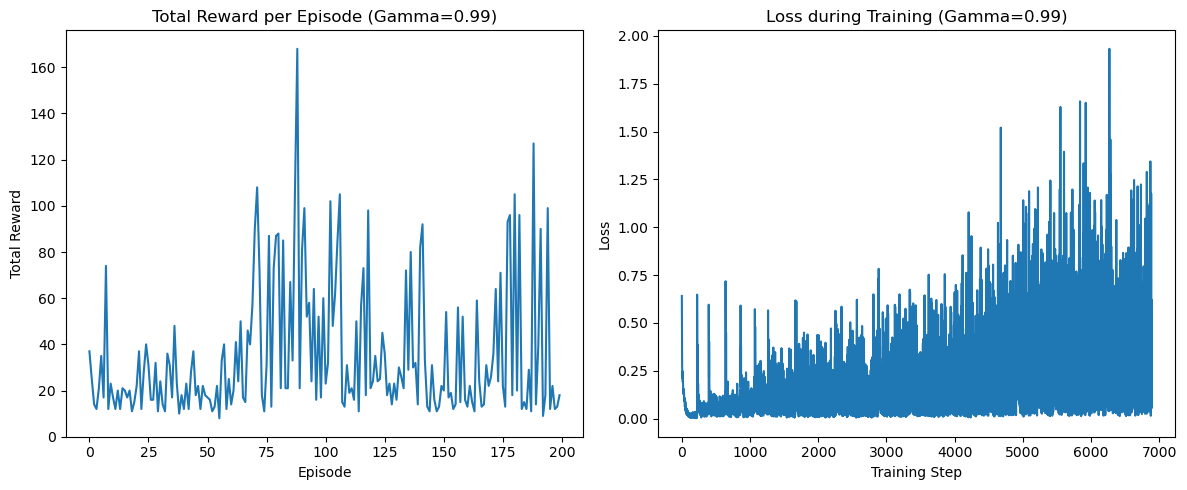

In [186]:
for gamma in gammas:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results_gamma[gamma]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Gamma={gamma})')
    
    axs[1].plot(results_gamma[gamma]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Gamma={gamma})')
    plt.tight_layout()
    plt.show()

##### **Q27: How do you experiment with different batch sizes for sampling experiences from the replay buffer to improve training efficiency?**



Training with batch size: 32
Episode 0, Total Reward: 27.0, Epsilon: 0.99
Episode 10, Total Reward: 10.0, Epsilon: 0.95
Episode 20, Total Reward: 15.0, Epsilon: 0.90
Episode 30, Total Reward: 17.0, Epsilon: 0.86
Episode 40, Total Reward: 31.0, Epsilon: 0.81
Episode 50, Total Reward: 14.0, Epsilon: 0.77
Episode 60, Total Reward: 50.0, Epsilon: 0.74
Episode 70, Total Reward: 25.0, Epsilon: 0.70
Episode 80, Total Reward: 17.0, Epsilon: 0.67
Episode 90, Total Reward: 79.0, Epsilon: 0.63
Episode 100, Total Reward: 33.0, Epsilon: 0.60
Episode 110, Total Reward: 23.0, Epsilon: 0.57
Episode 120, Total Reward: 39.0, Epsilon: 0.55
Episode 130, Total Reward: 20.0, Epsilon: 0.52
Episode 140, Total Reward: 24.0, Epsilon: 0.49
Episode 150, Total Reward: 21.0, Epsilon: 0.47
Episode 160, Total Reward: 12.0, Epsilon: 0.45
Episode 170, Total Reward: 12.0, Epsilon: 0.42
Episode 180, Total Reward: 16.0, Epsilon: 0.40
Episode 190, Total Reward: 14.0, Epsilon: 0.38


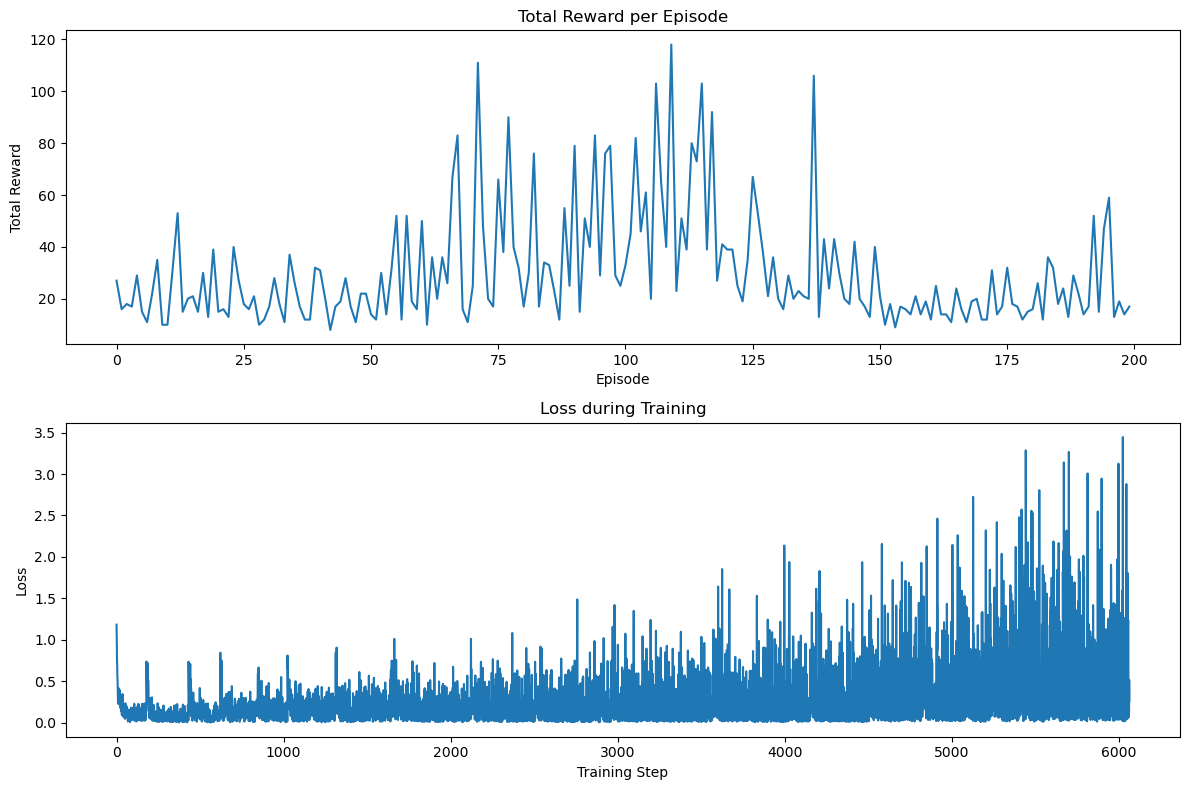

Average Reward over 10 evaluation episodes: 39.4

Training with batch size: 64
Episode 0, Total Reward: 10.0, Epsilon: 0.99
Episode 10, Total Reward: 11.0, Epsilon: 0.95
Episode 20, Total Reward: 19.0, Epsilon: 0.90
Episode 30, Total Reward: 21.0, Epsilon: 0.86
Episode 40, Total Reward: 21.0, Epsilon: 0.81
Episode 50, Total Reward: 17.0, Epsilon: 0.77
Episode 60, Total Reward: 14.0, Epsilon: 0.74
Episode 70, Total Reward: 30.0, Epsilon: 0.70
Episode 80, Total Reward: 95.0, Epsilon: 0.67
Episode 90, Total Reward: 17.0, Epsilon: 0.63
Episode 100, Total Reward: 51.0, Epsilon: 0.60
Episode 110, Total Reward: 62.0, Epsilon: 0.57
Episode 120, Total Reward: 13.0, Epsilon: 0.55
Episode 130, Total Reward: 15.0, Epsilon: 0.52
Episode 140, Total Reward: 13.0, Epsilon: 0.49
Episode 150, Total Reward: 14.0, Epsilon: 0.47
Episode 160, Total Reward: 97.0, Epsilon: 0.45
Episode 170, Total Reward: 10.0, Epsilon: 0.42
Episode 180, Total Reward: 28.0, Epsilon: 0.40
Episode 190, Total Reward: 24.0, Epsilo

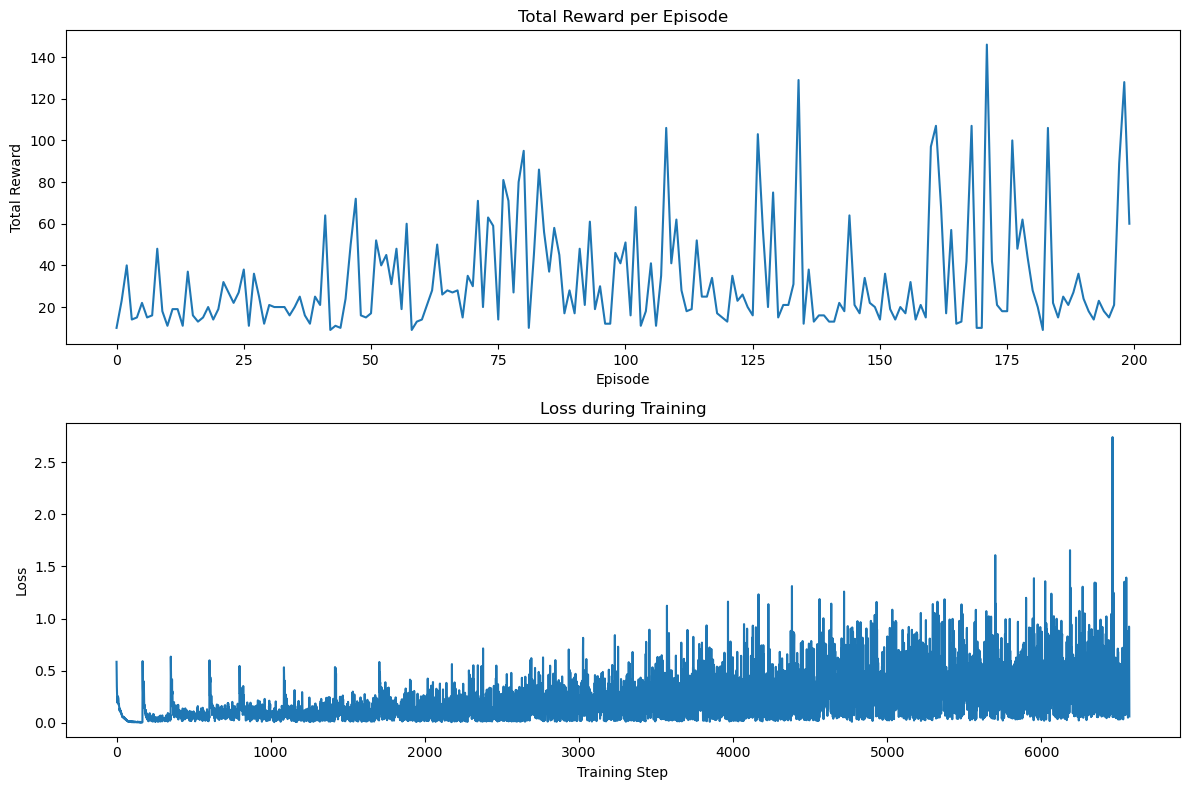

Average Reward over 10 evaluation episodes: 59.8

Training with batch size: 128
Episode 0, Total Reward: 29.0, Epsilon: 0.99
Episode 10, Total Reward: 20.0, Epsilon: 0.95
Episode 20, Total Reward: 25.0, Epsilon: 0.90
Episode 30, Total Reward: 55.0, Epsilon: 0.86
Episode 40, Total Reward: 43.0, Epsilon: 0.81
Episode 50, Total Reward: 18.0, Epsilon: 0.77
Episode 60, Total Reward: 84.0, Epsilon: 0.74
Episode 70, Total Reward: 43.0, Epsilon: 0.70
Episode 80, Total Reward: 137.0, Epsilon: 0.67
Episode 90, Total Reward: 81.0, Epsilon: 0.63
Episode 100, Total Reward: 13.0, Epsilon: 0.60
Episode 110, Total Reward: 49.0, Epsilon: 0.57
Episode 120, Total Reward: 27.0, Epsilon: 0.55
Episode 130, Total Reward: 49.0, Epsilon: 0.52
Episode 140, Total Reward: 43.0, Epsilon: 0.49
Episode 150, Total Reward: 36.0, Epsilon: 0.47
Episode 160, Total Reward: 57.0, Epsilon: 0.45
Episode 170, Total Reward: 14.0, Epsilon: 0.42
Episode 180, Total Reward: 18.0, Epsilon: 0.40
Episode 190, Total Reward: 95.0, Epsi

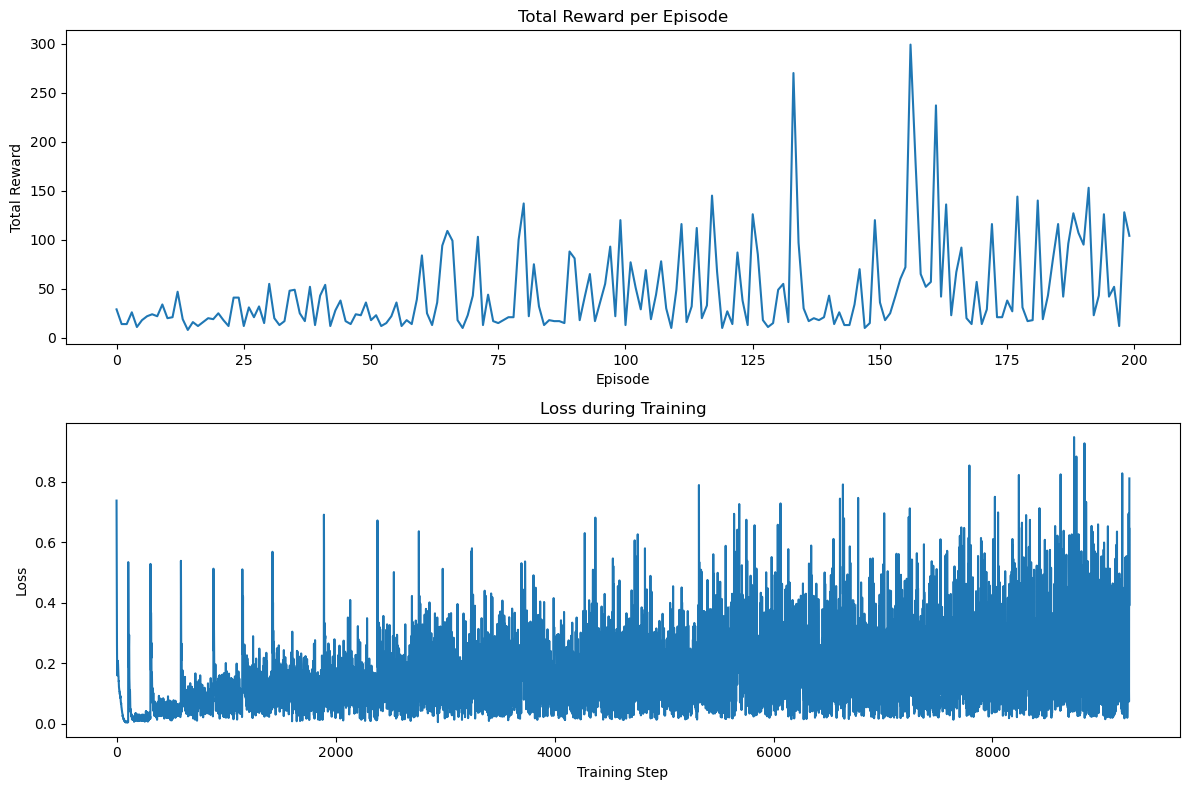

Average Reward over 10 evaluation episodes: 101.6


In [187]:
batch_sizes = [32, 64, 128]
results_batch_size = {}

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        batch_size=batch_size,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    results_batch_size[batch_size] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

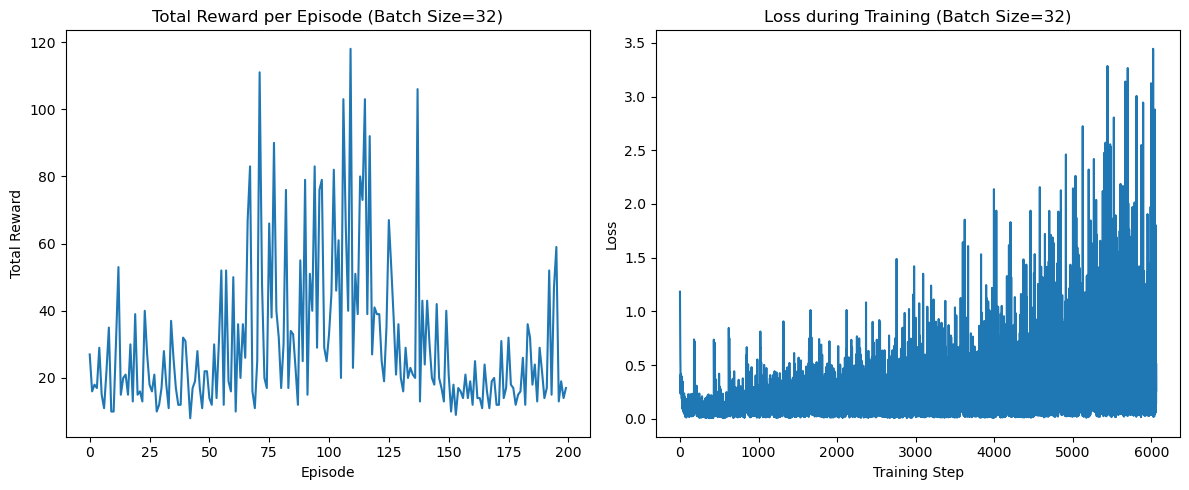

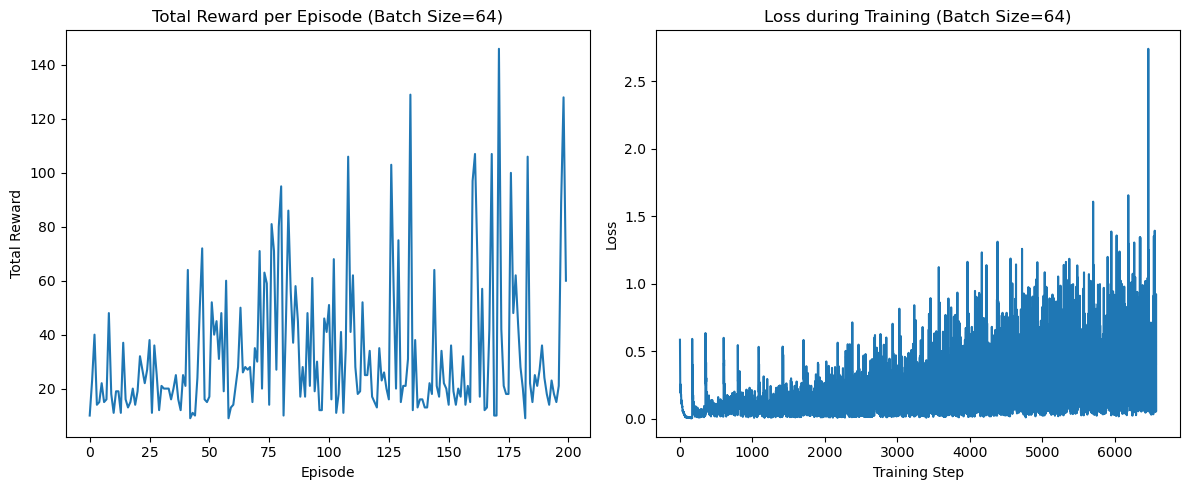

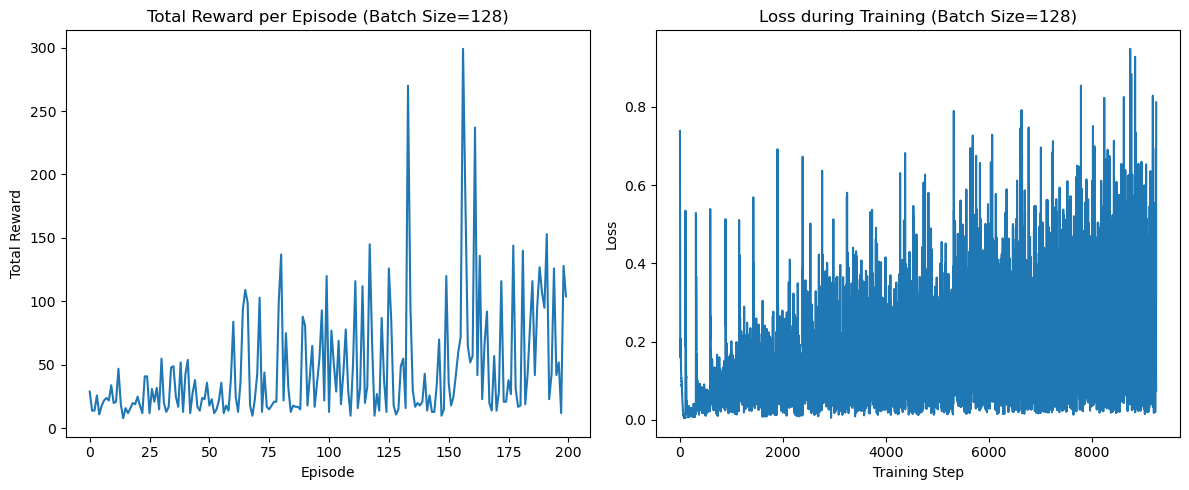

In [188]:
for batch_size in batch_sizes:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results_batch_size[batch_size]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Batch Size={batch_size})')
    
    axs[1].plot(results_batch_size[batch_size]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Batch Size={batch_size})')
    plt.tight_layout()
    plt.show()

##### **Q28: How do you experiment with different architectures for the Q-network to improve the model's learning capacity?**



Training with hidden layers: [64, 64]
Episode 0, Total Reward: 28.0, Epsilon: 0.99
Episode 10, Total Reward: 13.0, Epsilon: 0.95
Episode 20, Total Reward: 23.0, Epsilon: 0.90
Episode 30, Total Reward: 16.0, Epsilon: 0.86
Episode 40, Total Reward: 12.0, Epsilon: 0.81
Episode 50, Total Reward: 26.0, Epsilon: 0.77
Episode 60, Total Reward: 22.0, Epsilon: 0.74
Episode 70, Total Reward: 50.0, Epsilon: 0.70
Episode 80, Total Reward: 43.0, Epsilon: 0.67
Episode 90, Total Reward: 46.0, Epsilon: 0.63
Episode 100, Total Reward: 21.0, Epsilon: 0.60
Episode 110, Total Reward: 47.0, Epsilon: 0.57
Episode 120, Total Reward: 57.0, Epsilon: 0.55
Episode 130, Total Reward: 58.0, Epsilon: 0.52
Episode 140, Total Reward: 43.0, Epsilon: 0.49
Episode 150, Total Reward: 81.0, Epsilon: 0.47
Episode 160, Total Reward: 55.0, Epsilon: 0.45
Episode 170, Total Reward: 49.0, Epsilon: 0.42
Episode 180, Total Reward: 25.0, Epsilon: 0.40
Episode 190, Total Reward: 39.0, Epsilon: 0.38


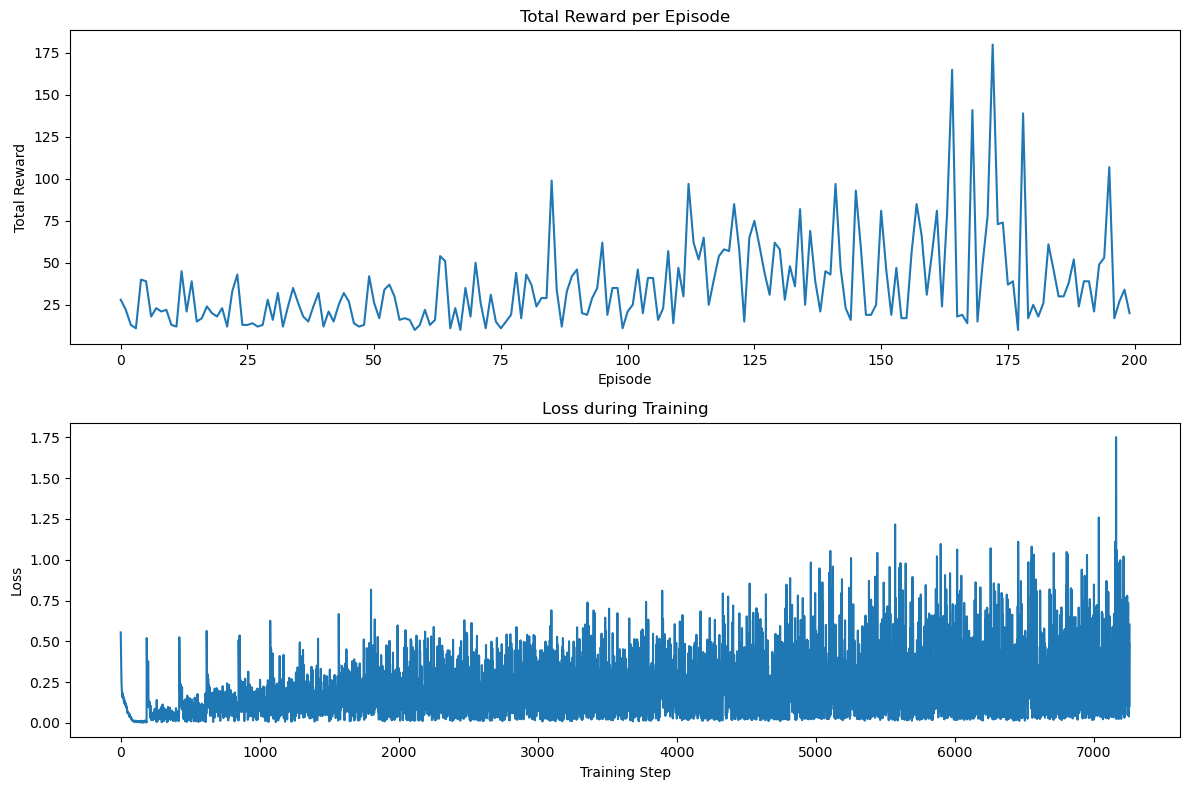

Average Reward over 10 evaluation episodes: 51.6

Training with hidden layers: [128, 128]
Episode 0, Total Reward: 30.0, Epsilon: 0.99
Episode 10, Total Reward: 11.0, Epsilon: 0.95
Episode 20, Total Reward: 16.0, Epsilon: 0.90
Episode 30, Total Reward: 28.0, Epsilon: 0.86
Episode 40, Total Reward: 18.0, Epsilon: 0.81
Episode 50, Total Reward: 13.0, Epsilon: 0.77
Episode 60, Total Reward: 25.0, Epsilon: 0.74
Episode 70, Total Reward: 17.0, Epsilon: 0.70
Episode 80, Total Reward: 29.0, Epsilon: 0.67
Episode 90, Total Reward: 85.0, Epsilon: 0.63
Episode 100, Total Reward: 13.0, Epsilon: 0.60
Episode 110, Total Reward: 33.0, Epsilon: 0.57
Episode 120, Total Reward: 181.0, Epsilon: 0.55
Episode 130, Total Reward: 86.0, Epsilon: 0.52
Episode 140, Total Reward: 20.0, Epsilon: 0.49
Episode 150, Total Reward: 43.0, Epsilon: 0.47
Episode 160, Total Reward: 24.0, Epsilon: 0.45
Episode 170, Total Reward: 40.0, Epsilon: 0.42
Episode 180, Total Reward: 19.0, Epsilon: 0.40
Episode 190, Total Reward: 

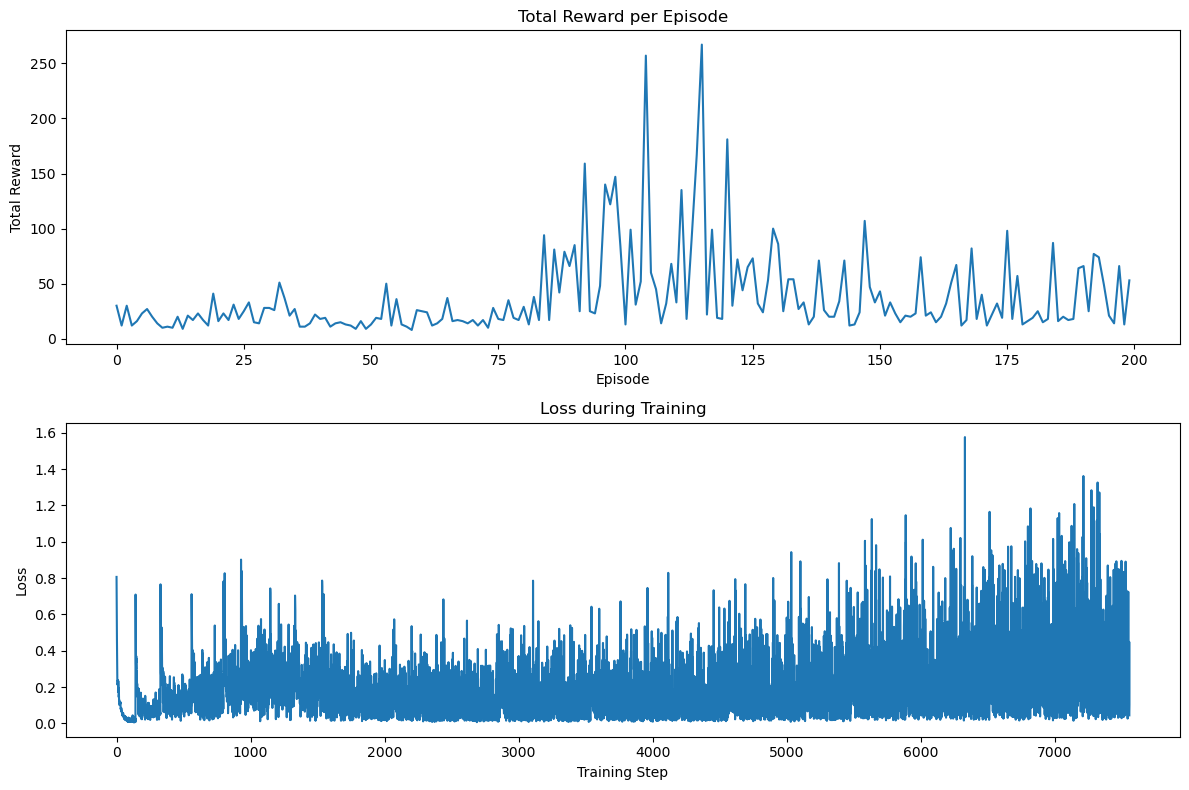

Average Reward over 10 evaluation episodes: 108.4

Training with hidden layers: [256, 256]
Episode 0, Total Reward: 44.0, Epsilon: 0.99
Episode 10, Total Reward: 13.0, Epsilon: 0.95
Episode 20, Total Reward: 14.0, Epsilon: 0.90
Episode 30, Total Reward: 11.0, Epsilon: 0.86
Episode 40, Total Reward: 16.0, Epsilon: 0.81
Episode 50, Total Reward: 19.0, Epsilon: 0.77
Episode 60, Total Reward: 13.0, Epsilon: 0.74
Episode 70, Total Reward: 59.0, Epsilon: 0.70
Episode 80, Total Reward: 47.0, Epsilon: 0.67
Episode 90, Total Reward: 104.0, Epsilon: 0.63
Episode 100, Total Reward: 73.0, Epsilon: 0.60
Episode 110, Total Reward: 24.0, Epsilon: 0.57
Episode 120, Total Reward: 16.0, Epsilon: 0.55
Episode 130, Total Reward: 17.0, Epsilon: 0.52
Episode 140, Total Reward: 21.0, Epsilon: 0.49
Episode 150, Total Reward: 19.0, Epsilon: 0.47
Episode 160, Total Reward: 15.0, Epsilon: 0.45
Episode 170, Total Reward: 30.0, Epsilon: 0.42
Episode 180, Total Reward: 44.0, Epsilon: 0.40
Episode 190, Total Reward:

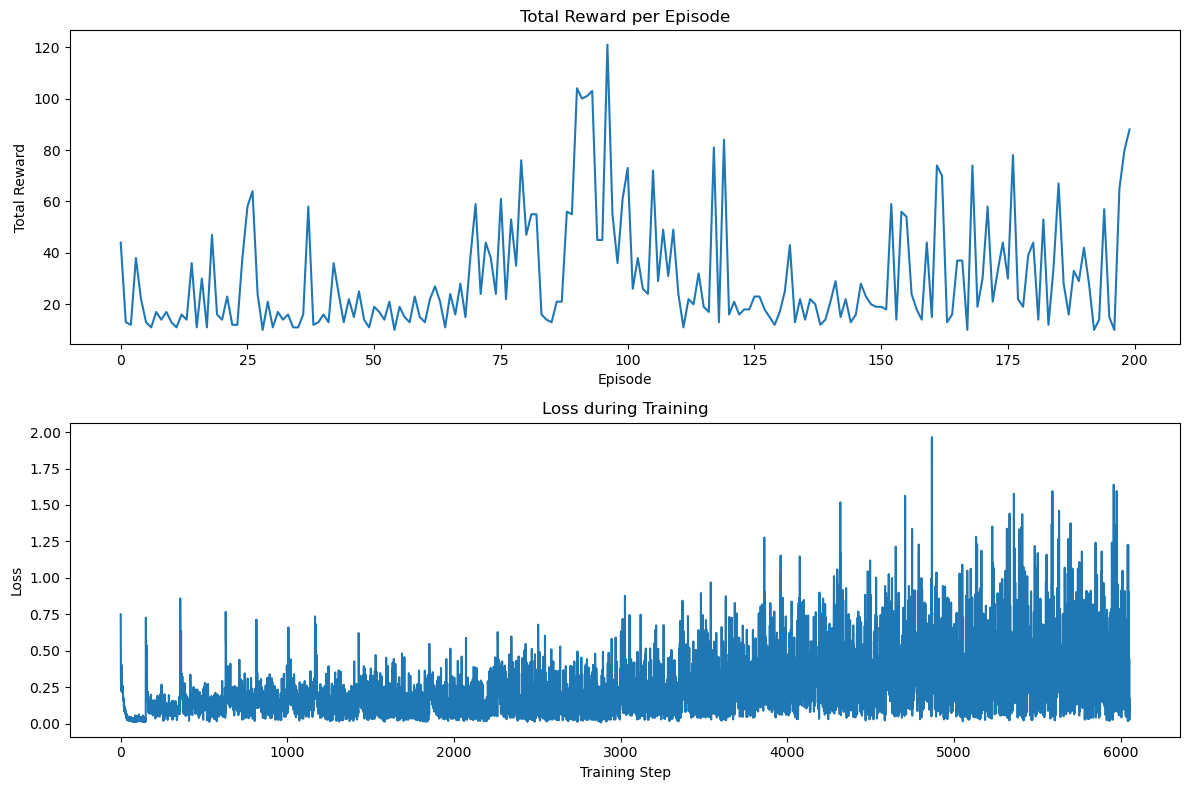

Average Reward over 10 evaluation episodes: 99.1


In [189]:
architectures = [[64, 64], [128, 128], [256, 256]]
results_architecture = {}

for hidden_layers in architectures:
    print(f"\nTraining with hidden layers: {hidden_layers}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        hidden_layers=hidden_layers,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    arch_key = '-'.join(map(str, hidden_layers))
    results_architecture[arch_key] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

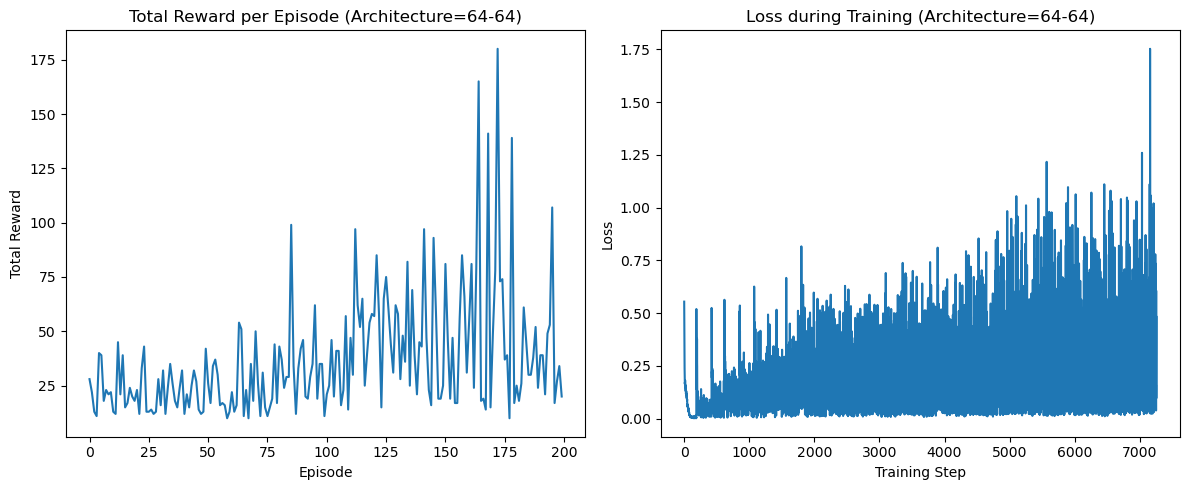

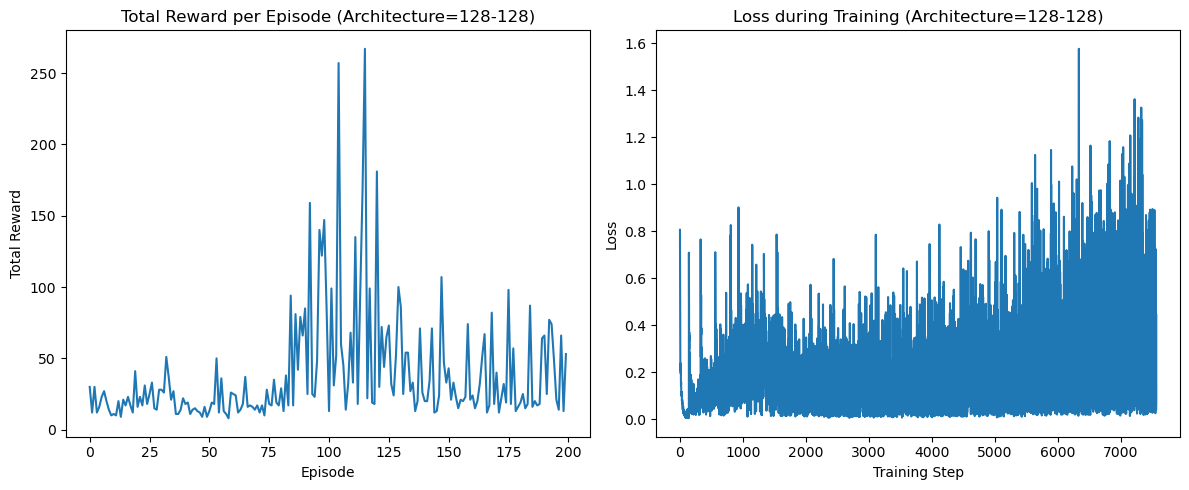

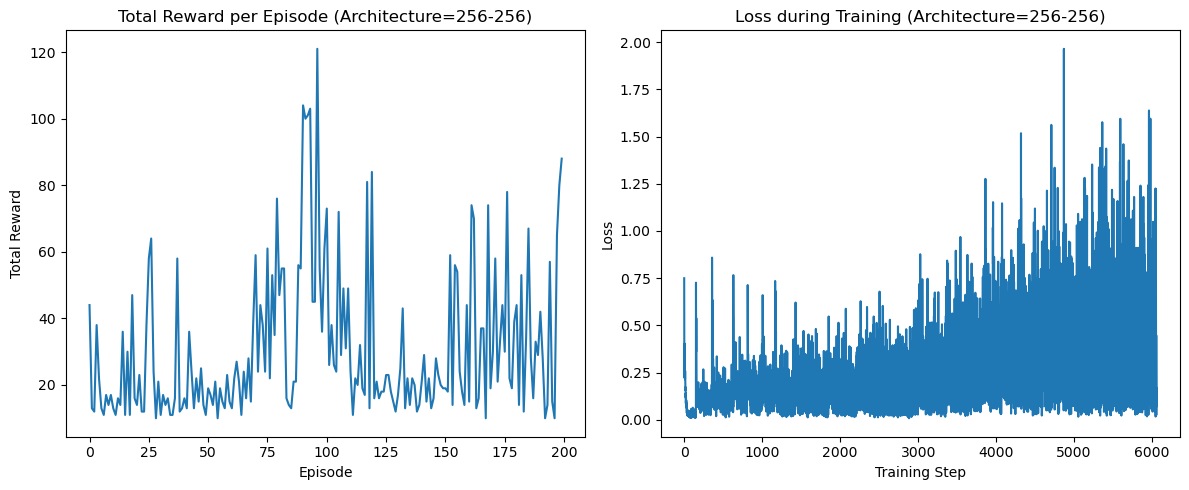

In [190]:
for arch_key in results_architecture:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results_architecture[arch_key]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Architecture={arch_key})')
    
    axs[1].plot(results_architecture[arch_key]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Architecture={arch_key})')
    plt.tight_layout()
    plt.show()

##### **Q29: How do you adjust the epsilon decay rate to control how quickly the agent shifts from exploration to exploitation?**



Training with epsilon decay rate: 0.99
Episode 0, Total Reward: 23.0, Epsilon: 0.99
Episode 10, Total Reward: 10.0, Epsilon: 0.90
Episode 20, Total Reward: 16.0, Epsilon: 0.81
Episode 30, Total Reward: 8.0, Epsilon: 0.73
Episode 40, Total Reward: 10.0, Epsilon: 0.66
Episode 50, Total Reward: 24.0, Epsilon: 0.60
Episode 60, Total Reward: 10.0, Epsilon: 0.54
Episode 70, Total Reward: 78.0, Epsilon: 0.49
Episode 80, Total Reward: 87.0, Epsilon: 0.44
Episode 90, Total Reward: 78.0, Epsilon: 0.40
Episode 100, Total Reward: 38.0, Epsilon: 0.36
Episode 110, Total Reward: 67.0, Epsilon: 0.33
Episode 120, Total Reward: 38.0, Epsilon: 0.30
Episode 130, Total Reward: 58.0, Epsilon: 0.27
Episode 140, Total Reward: 20.0, Epsilon: 0.24
Episode 150, Total Reward: 91.0, Epsilon: 0.22
Episode 160, Total Reward: 28.0, Epsilon: 0.20
Episode 170, Total Reward: 93.0, Epsilon: 0.18
Episode 180, Total Reward: 95.0, Epsilon: 0.16
Episode 190, Total Reward: 55.0, Epsilon: 0.15


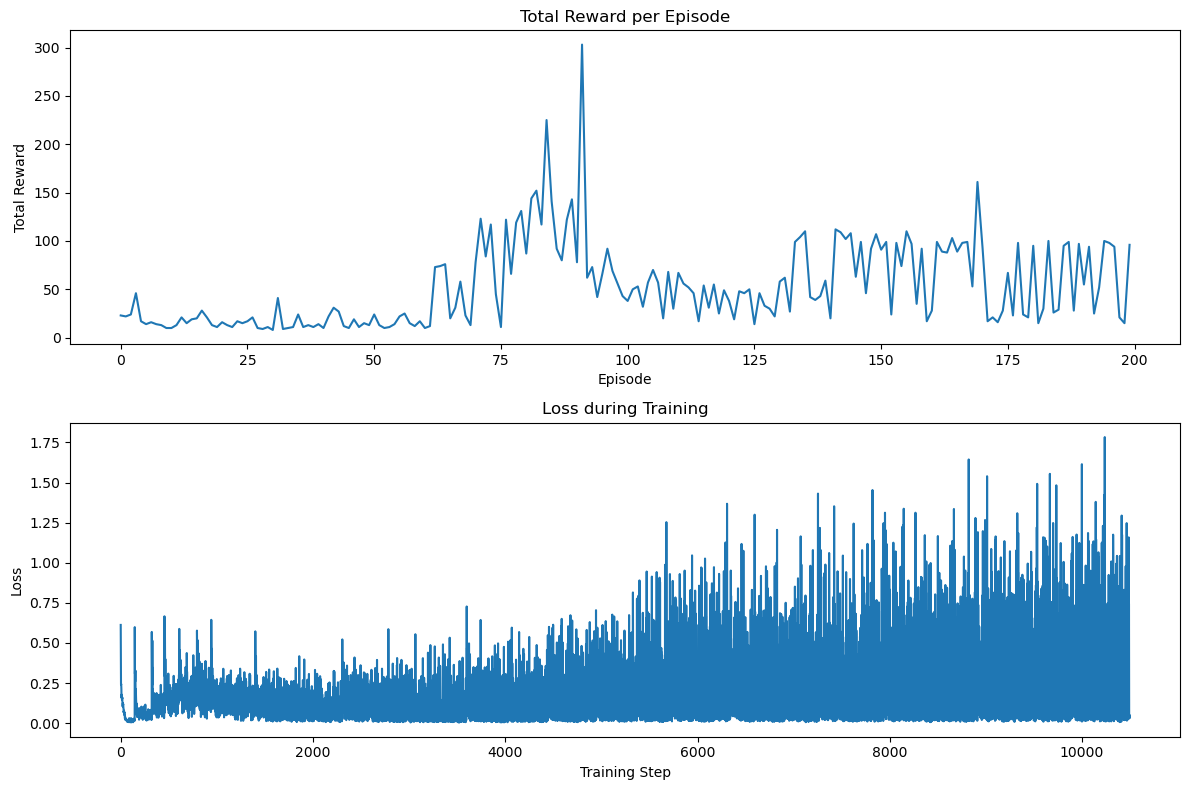

Average Reward over 10 evaluation episodes: 93.9

Training with epsilon decay rate: 0.995
Episode 0, Total Reward: 32.0, Epsilon: 0.99
Episode 10, Total Reward: 22.0, Epsilon: 0.95
Episode 20, Total Reward: 29.0, Epsilon: 0.90
Episode 30, Total Reward: 18.0, Epsilon: 0.86
Episode 40, Total Reward: 35.0, Epsilon: 0.81
Episode 50, Total Reward: 14.0, Epsilon: 0.77
Episode 60, Total Reward: 11.0, Epsilon: 0.74
Episode 70, Total Reward: 23.0, Epsilon: 0.70
Episode 80, Total Reward: 104.0, Epsilon: 0.67
Episode 90, Total Reward: 70.0, Epsilon: 0.63
Episode 100, Total Reward: 63.0, Epsilon: 0.60
Episode 110, Total Reward: 101.0, Epsilon: 0.57
Episode 120, Total Reward: 19.0, Epsilon: 0.55
Episode 130, Total Reward: 246.0, Epsilon: 0.52
Episode 140, Total Reward: 17.0, Epsilon: 0.49
Episode 150, Total Reward: 29.0, Epsilon: 0.47
Episode 160, Total Reward: 137.0, Epsilon: 0.45
Episode 170, Total Reward: 18.0, Epsilon: 0.42
Episode 180, Total Reward: 38.0, Epsilon: 0.40
Episode 190, Total Rewar

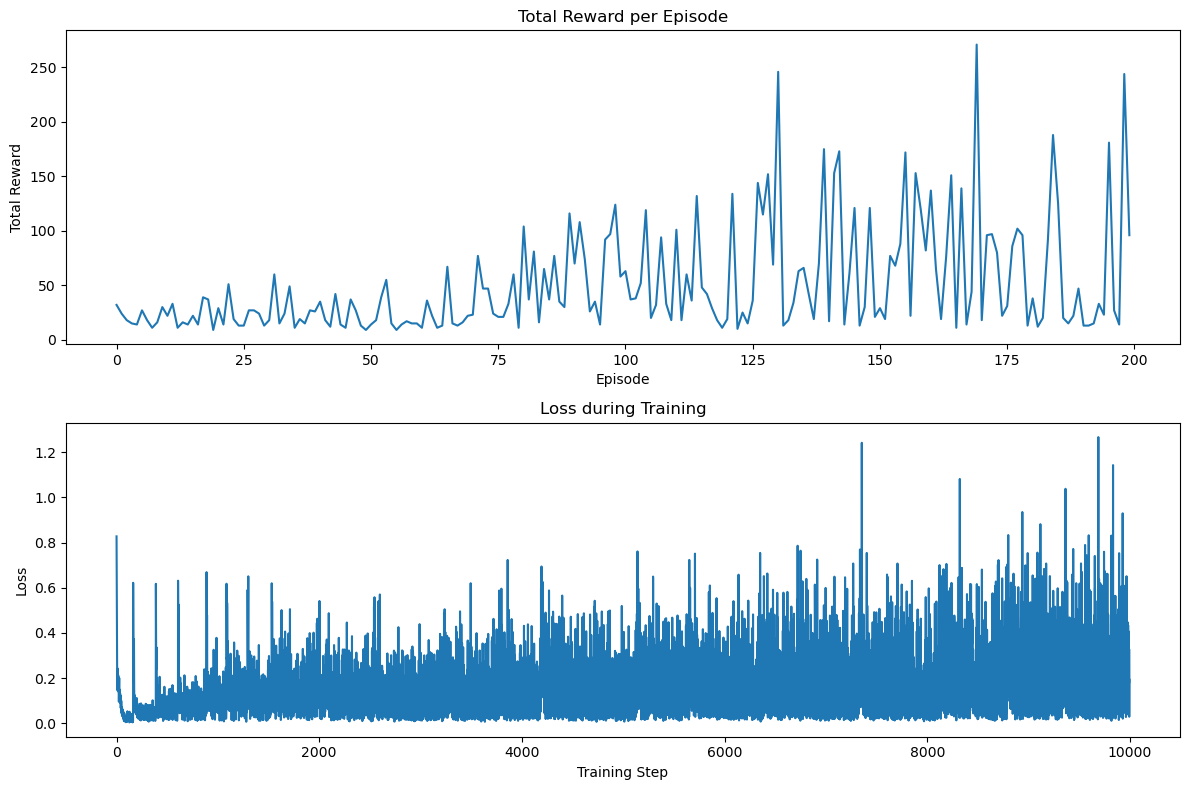

Average Reward over 10 evaluation episodes: 199.0

Training with epsilon decay rate: 0.999
Episode 0, Total Reward: 12.0, Epsilon: 1.00
Episode 10, Total Reward: 14.0, Epsilon: 0.99
Episode 20, Total Reward: 10.0, Epsilon: 0.98
Episode 30, Total Reward: 27.0, Epsilon: 0.97
Episode 40, Total Reward: 9.0, Epsilon: 0.96
Episode 50, Total Reward: 17.0, Epsilon: 0.95
Episode 60, Total Reward: 12.0, Epsilon: 0.94
Episode 70, Total Reward: 19.0, Epsilon: 0.93
Episode 80, Total Reward: 16.0, Epsilon: 0.92
Episode 90, Total Reward: 42.0, Epsilon: 0.91
Episode 100, Total Reward: 22.0, Epsilon: 0.90
Episode 110, Total Reward: 62.0, Epsilon: 0.89
Episode 120, Total Reward: 14.0, Epsilon: 0.89
Episode 130, Total Reward: 18.0, Epsilon: 0.88
Episode 140, Total Reward: 30.0, Epsilon: 0.87
Episode 150, Total Reward: 15.0, Epsilon: 0.86
Episode 160, Total Reward: 35.0, Epsilon: 0.85
Episode 170, Total Reward: 10.0, Epsilon: 0.84
Episode 180, Total Reward: 16.0, Epsilon: 0.83
Episode 190, Total Reward: 2

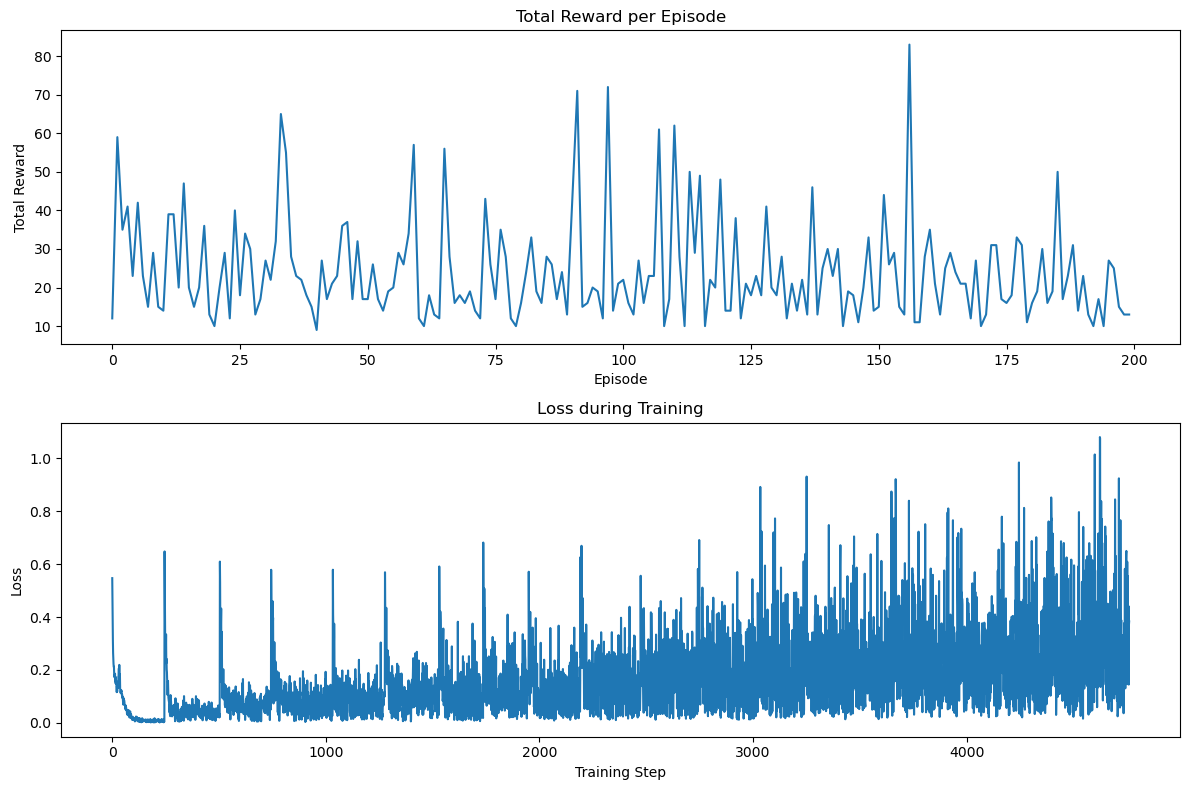

Average Reward over 10 evaluation episodes: 90.7


In [191]:
epsilon_decays = [0.99, 0.995, 0.999]
results_epsilon_decay = {}

for decay in epsilon_decays:
    print(f"\nTraining with epsilon decay rate: {decay}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        epsilon_decay=decay,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    results_epsilon_decay[decay] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

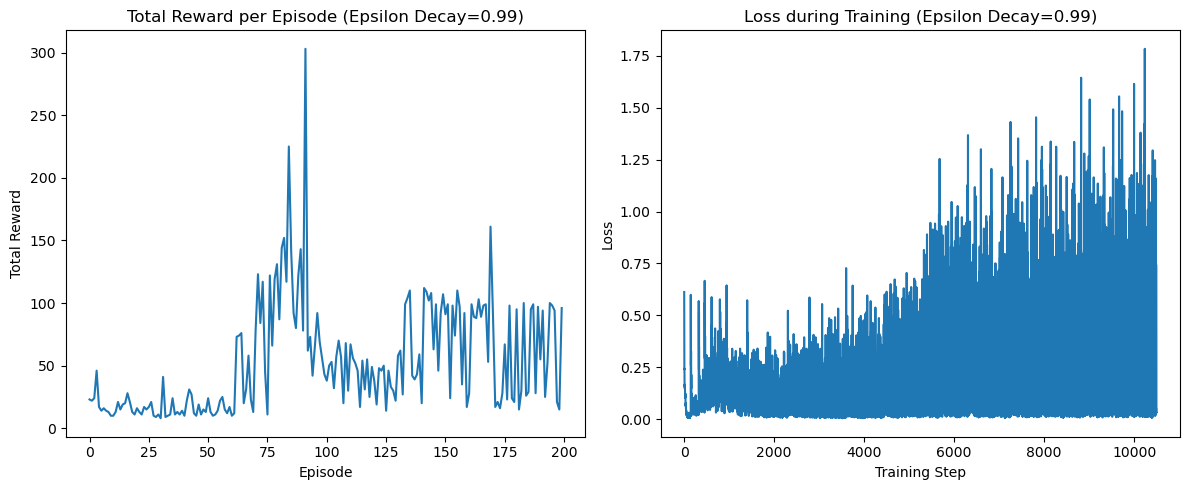

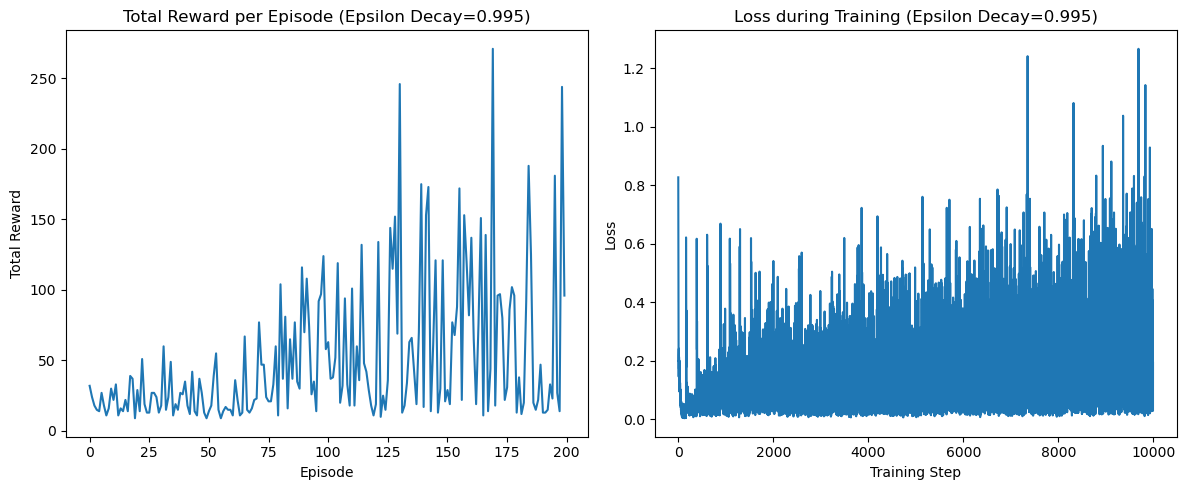

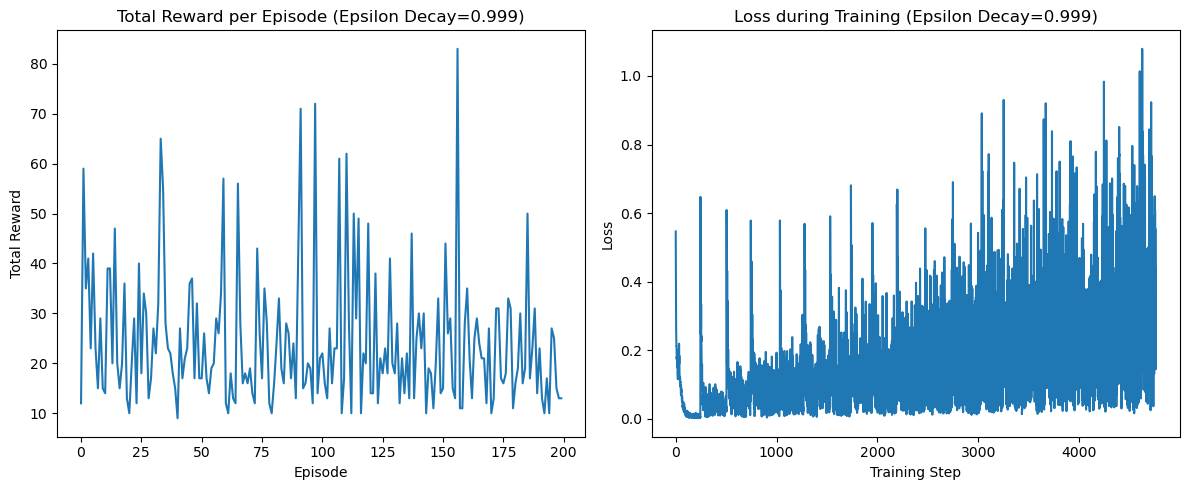

In [192]:
for decay in epsilon_decays:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results_epsilon_decay[decay]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Epsilon Decay={decay})')
    
    axs[1].plot(results_epsilon_decay[decay]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Epsilon Decay={decay})')
    plt.tight_layout()
    plt.show()

##### **Q30: How do you adjust the target network update frequency, and how does it affect the stability of training?**


Training with target network update frequency: 1
Episode 0, Total Reward: 17.0, Epsilon: 0.99
Episode 10, Total Reward: 25.0, Epsilon: 0.95
Episode 20, Total Reward: 24.0, Epsilon: 0.90
Episode 30, Total Reward: 12.0, Epsilon: 0.86
Episode 40, Total Reward: 22.0, Epsilon: 0.81
Episode 50, Total Reward: 12.0, Epsilon: 0.77
Episode 60, Total Reward: 12.0, Epsilon: 0.74
Episode 70, Total Reward: 14.0, Epsilon: 0.70
Episode 80, Total Reward: 35.0, Epsilon: 0.67
Episode 90, Total Reward: 13.0, Epsilon: 0.63
Episode 100, Total Reward: 10.0, Epsilon: 0.60
Episode 110, Total Reward: 12.0, Epsilon: 0.57
Episode 120, Total Reward: 15.0, Epsilon: 0.55
Episode 130, Total Reward: 18.0, Epsilon: 0.52
Episode 140, Total Reward: 16.0, Epsilon: 0.49
Episode 150, Total Reward: 11.0, Epsilon: 0.47
Episode 160, Total Reward: 10.0, Epsilon: 0.45
Episode 170, Total Reward: 9.0, Epsilon: 0.42
Episode 180, Total Reward: 10.0, Epsilon: 0.40
Episode 190, Total Reward: 13.0, Epsilon: 0.38


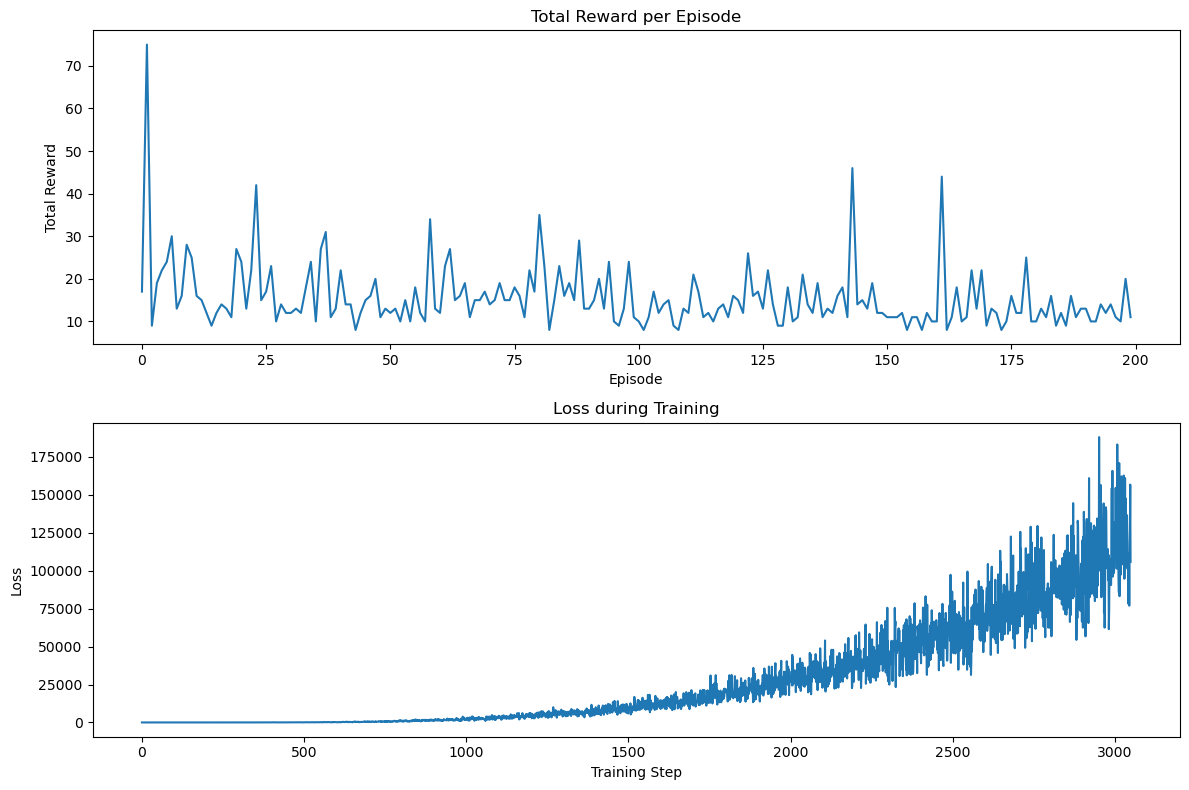

Average Reward over 10 evaluation episodes: 9.4

Training with target network update frequency: 10
Episode 0, Total Reward: 12.0, Epsilon: 0.99
Episode 10, Total Reward: 19.0, Epsilon: 0.95
Episode 20, Total Reward: 13.0, Epsilon: 0.90
Episode 30, Total Reward: 12.0, Epsilon: 0.86
Episode 40, Total Reward: 9.0, Epsilon: 0.81
Episode 50, Total Reward: 23.0, Epsilon: 0.77
Episode 60, Total Reward: 22.0, Epsilon: 0.74
Episode 70, Total Reward: 15.0, Epsilon: 0.70
Episode 80, Total Reward: 14.0, Epsilon: 0.67
Episode 90, Total Reward: 38.0, Epsilon: 0.63
Episode 100, Total Reward: 29.0, Epsilon: 0.60
Episode 110, Total Reward: 39.0, Epsilon: 0.57
Episode 120, Total Reward: 12.0, Epsilon: 0.55
Episode 130, Total Reward: 22.0, Epsilon: 0.52
Episode 140, Total Reward: 74.0, Epsilon: 0.49
Episode 150, Total Reward: 24.0, Epsilon: 0.47
Episode 160, Total Reward: 38.0, Epsilon: 0.45
Episode 170, Total Reward: 16.0, Epsilon: 0.42
Episode 180, Total Reward: 18.0, Epsilon: 0.40
Episode 190, Total R

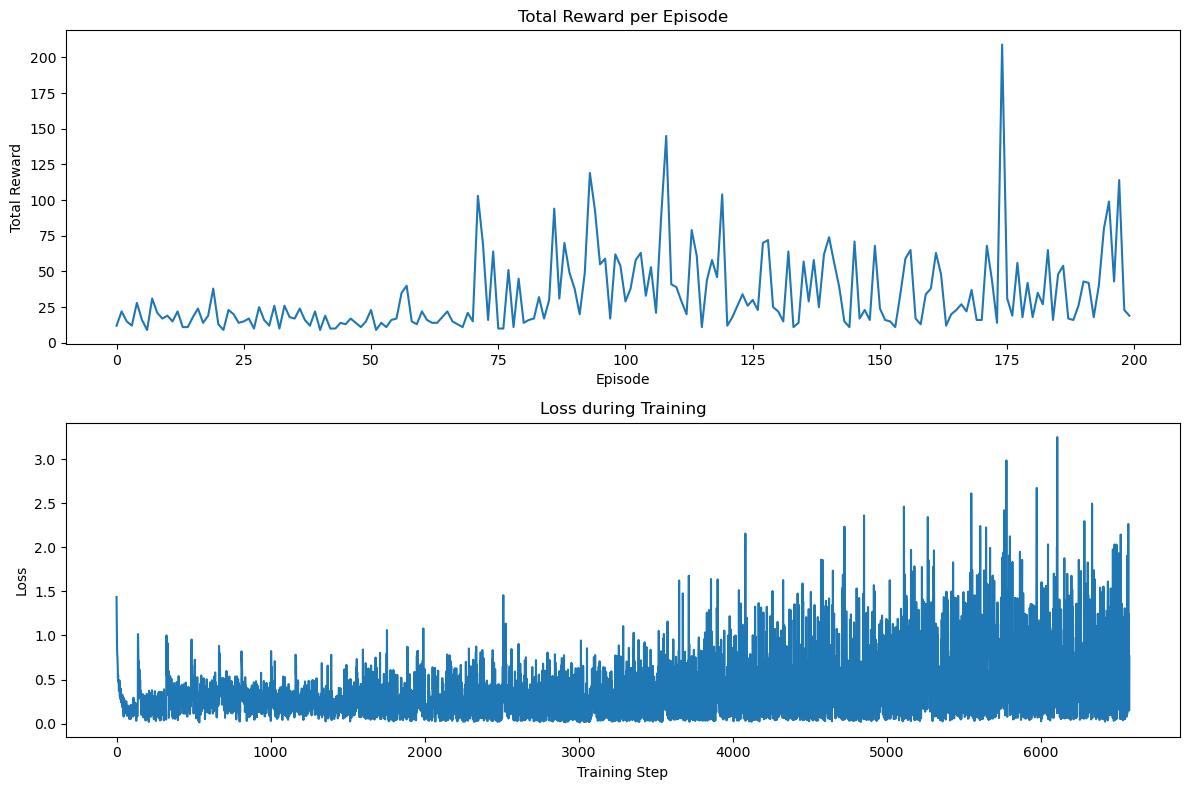

Average Reward over 10 evaluation episodes: 117.4

Training with target network update frequency: 50
Episode 0, Total Reward: 21.0, Epsilon: 0.99
Episode 10, Total Reward: 17.0, Epsilon: 0.95
Episode 20, Total Reward: 19.0, Epsilon: 0.90
Episode 30, Total Reward: 10.0, Epsilon: 0.86
Episode 40, Total Reward: 13.0, Epsilon: 0.81
Episode 50, Total Reward: 20.0, Epsilon: 0.77
Episode 60, Total Reward: 21.0, Epsilon: 0.74
Episode 70, Total Reward: 23.0, Epsilon: 0.70
Episode 80, Total Reward: 14.0, Epsilon: 0.67
Episode 90, Total Reward: 10.0, Epsilon: 0.63
Episode 100, Total Reward: 13.0, Epsilon: 0.60
Episode 110, Total Reward: 9.0, Epsilon: 0.57
Episode 120, Total Reward: 10.0, Epsilon: 0.55
Episode 130, Total Reward: 12.0, Epsilon: 0.52
Episode 140, Total Reward: 11.0, Epsilon: 0.49
Episode 150, Total Reward: 22.0, Epsilon: 0.47
Episode 160, Total Reward: 14.0, Epsilon: 0.45
Episode 170, Total Reward: 14.0, Epsilon: 0.42
Episode 180, Total Reward: 26.0, Epsilon: 0.40
Episode 190, Total

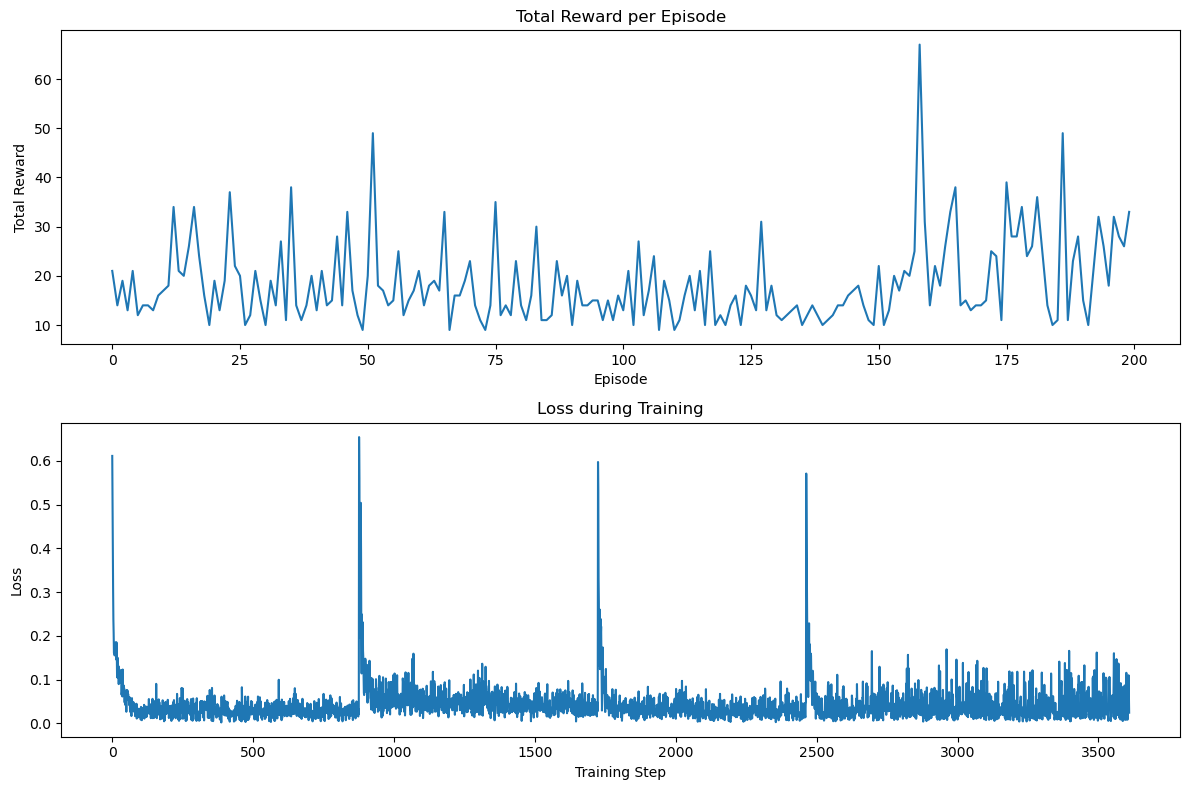

Average Reward over 10 evaluation episodes: 32.7


In [193]:
target_updates = [1, 10, 50]
results_target_update = {}

for update_freq in target_updates:
    print(f"\nTraining with target network update frequency: {update_freq}")
    policy_net, episode_rewards, losses = train_dqn(
        env,
        target_update=update_freq,
        num_episodes=200,
        verbose=True
    )
    evaluation_rewards = evaluate_policy(policy_net, env, n_episodes=10)
    results_target_update[update_freq] = {
        'episode_rewards': episode_rewards,
        'losses': losses,
        'evaluation_rewards': evaluation_rewards
    }

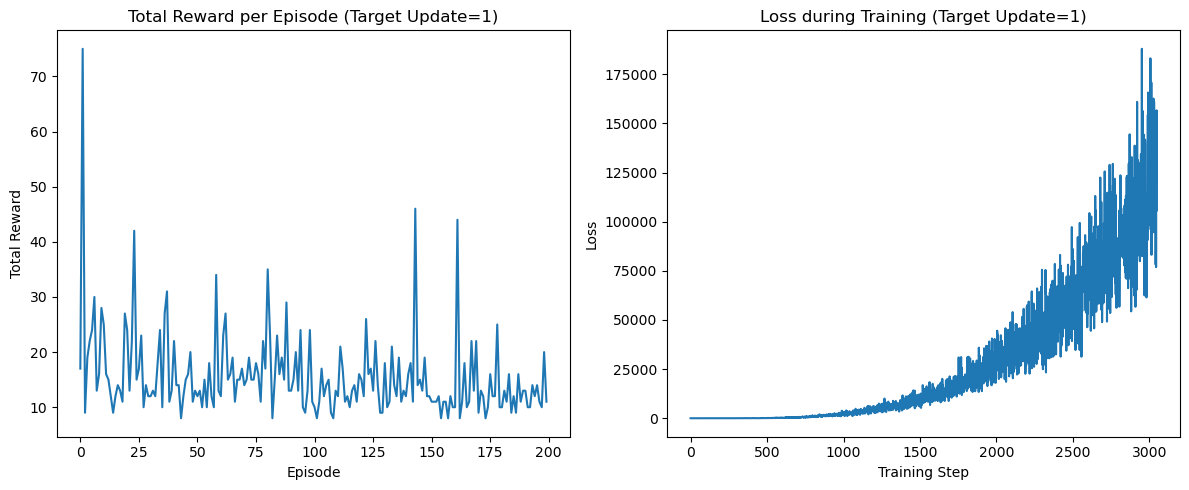

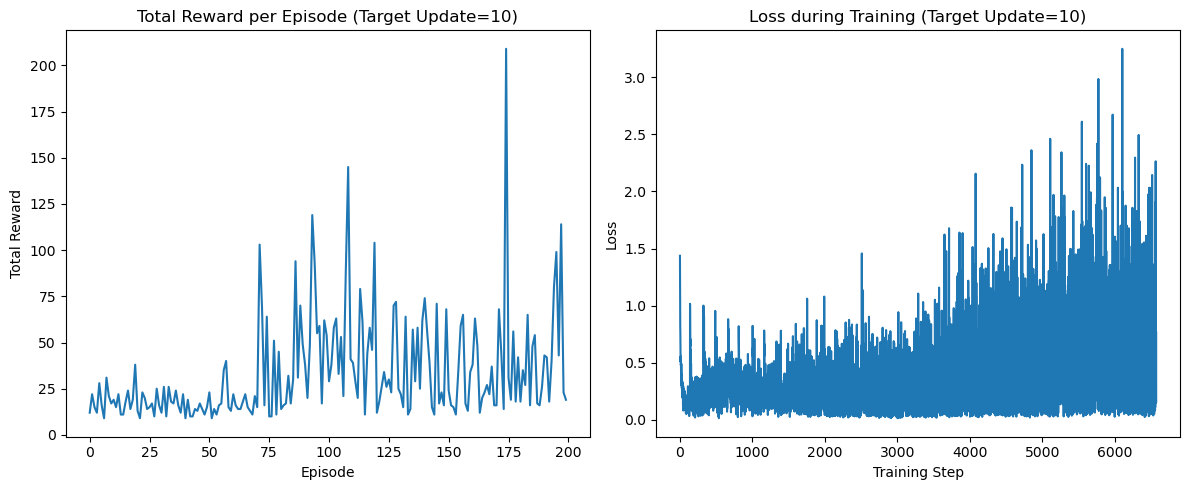

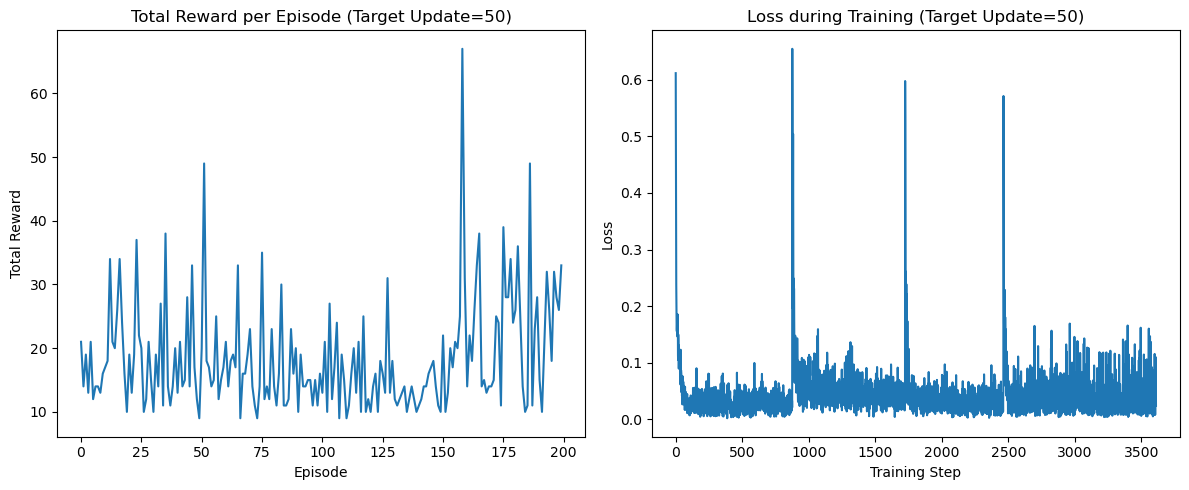

In [194]:
for update_freq in target_updates:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(results_target_update[update_freq]['episode_rewards'])
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title(f'Total Reward per Episode (Target Update={update_freq})')
    
    axs[1].plot(results_target_update[update_freq]['losses'])
    axs[1].set_xlabel('Training Step')
    axs[1].set_ylabel('Loss')
    axs[1].set_title(f'Loss during Training (Target Update={update_freq})')
    plt.tight_layout()
    plt.show()

In [195]:
import os
import glob

files_to_delete = glob.glob('*.pth')

for file_name in files_to_delete:
    if os.path.exists(file_name):
        os.remove(file_name)
        print(f'{file_name} deleted')
    else:
        print(f'{file_name} not found')

dqn_model.pth deleted
dqn_cartpole_model.pth deleted
